In [1]:
import gc
import os

import pandas as pd
import numpy as np
import warnings
import pickle
import polars as pl

from collections import defaultdict
from itertools import combinations
import pyarrow as pa

from xgboost import XGBClassifier

# from lightgbm import LGBMClassifier
# from lightgbm import early_stopping
# from lightgbm import log_evaluation

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve


import matplotlib.pyplot as plt
import seaborn as sns
# from colorama import Fore, Back, Style


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:

# Set max display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data preprocessing

In [3]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = [
        'hover_duration', 'elapsed_time_diff','room_coor_diff', 'screen_coor_diff','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',] #'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [4]:
import pandas as pd
import numpy as np

# Read the dataset
df = pd.read_csv("data/predict-student-performance-from-game-play/train.csv")

# Drop unnecessary columns
df = df.drop(columns=["fullscreen", "hq", "music", "page"])

# Fill null values
df["fqid"] = df["fqid"].fillna("fqid_None")
df["text_fqid"] = df["text_fqid"].fillna("text_fqid_None")

# Calculate elapsed_time_diff
df["elapsed_time_diff"] = (df["elapsed_time"] - df["elapsed_time"].shift(1)).fillna(0)
df["elapsed_time_diff"] = df.groupby(["session_id", "level_group"])["elapsed_time_diff"].transform(lambda x: x.clip(0, 1e9))

# Calculate screen_coor_diff
df["screen_coor_diff"] = np.sqrt((df["screen_coor_x"] - df["screen_coor_x"].shift(1)) ** 2 + (df["screen_coor_y"] - df["screen_coor_y"].shift(1)) ** 2)
df["screen_coor_diff"] = df.groupby(["session_id", "level_group"])["screen_coor_diff"].transform(lambda x: x.fillna(0))

# Calculate room_coor_diff
df["room_coor_diff"] = np.sqrt((df["room_coor_x"] - df["room_coor_x"].shift(1)) ** 2 + (df["room_coor_y"] - df["room_coor_y"].shift(1)) ** 2)
df["room_coor_diff"] = df.groupby(["session_id", "level_group"])["room_coor_diff"].transform(lambda x: x.fillna(0))

# Filter the dataset by level_group
df1 = df[df["level_group"] == '0-4']
df2 = df[df["level_group"] == '5-12']
df3 = df[df["level_group"] == '13-22']

print(df1.shape, df2.shape, df3.shape)

(3981005, 19) (8844238, 19) (13471703, 19)


In [8]:
df1

,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff,screen_coor_diff,room_coor_diff
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4,0.0,0.000000,0.000000
1,20090312431273200,1,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,1323.0,0.000000,0.000000
2,20090312431273200,2,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,0.0,0.000000,0.000000
3,20090312431273200,3,1147,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,316.0,0.000000,0.000000
4,20090312431273200,4,1863,person_click,basic,0,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,716.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26295605,22100221145014656,206,352635,navigate_click,undefined,4,-914.204218,-50.000000,26.0,380.0,NaN,NaN,toentry,tunic.kohlcenter.halloffame,text_fqid_None,0-4,332.0,2.236068,51.477768
26295606,22100221145014656,207,353336,map_hover,basic,4,NaN,NaN,NaN,NaN,84.0,NaN,tunic.kohlcenter,tunic.kohlcenter.halloffame,text_fqid_None,0-4,701.0,0.000000,0.000000
26295607,22100221145014656,208,354020,map_click,undefined,4,-549.217711,-2.000000,449.0,332.0,NaN,NaN,tunic.capitol_0,tunic.kohlcenter.halloffame,text_fqid_None,0-4,684.0,0.000000,0.000000
26295608,22100221145014656,209,356238,navigate_click,undefined,4,313.584260,107.913147,463.0,226.0,NaN,NaN,chap1_finale,tunic.capitol_0.hall,text_fqid_None,0-4,2218.0,106.920531,869.774765


In [9]:
import pandas as pd
import numpy as np

def create_aggregations(column, conditions, stats, feature_suffix, df):
    aggs = {}
    filtered_column = df.loc[conditions, column]
    for stat in stats:
        if stat == 'count':
            aggs[f"{column}_count_{feature_suffix}"] = filtered_column.count()
        elif stat == 'mean':
            aggs[f"{column}_mean_{feature_suffix}"] = filtered_column.mean()
        elif stat == 'std':
            aggs[f"{column}_std_{feature_suffix}"] = filtered_column.std()
        elif stat == 'min':
            aggs[f"{column}_min_{feature_suffix}"] = filtered_column.min()
        elif stat == 'max':
            aggs[f"{column}_max_{feature_suffix}"] = filtered_column.max()
        elif stat == 'sum':
            aggs[f"{column}_sum_{feature_suffix}"] = filtered_column.sum()
    return aggs

def feature_engineer(x, grp, use_extra, feature_suffix):
    stats = ['count', 'mean', 'std', 'min', 'max', 'sum']
    aggs = {}

    # Basic aggregation for each column
    for c in CATS:
        aggs[f"{c}_unique_{feature_suffix}"] = x[c].nunique()
    for c in NUMS:
        aggs[f"{c}_std_{feature_suffix}"] = x[c].std()
        aggs[f"{c}_mean_{feature_suffix}"] = x[c].mean()
        aggs[f"{c}_median_{feature_suffix}"] = x[c].median()
        aggs[f"{c}_min_{feature_suffix}"] = x[c].min()
        aggs[f"{c}_max_{feature_suffix}"] = x[c].max()
        aggs[f"{c}_sum_{feature_suffix}"] = x[c].sum()

    # Aggregations based on conditions
    for feature_list, column_name in [(fqid_lists, "fqid"), (text_lists, "text_fqid"), (room_lists, "room_fqid"),
                                      (event_name_feature, "event_name"), (name_feature, "name"), (LEVELS, "level"),
                                      (level_groups, "level_group")]:
        for c in feature_list:
            conditions = x[column_name] == c
            aggs.update(create_aggregations("elapsed_time_diff", conditions, stats, f"{c}_{feature_suffix}", x))

    # Special case for level and room_lists
    for c in LEVELS:
        for d in room_lists:
            conditions = (x["level"] == c) & (x["room_fqid"] == d)
            aggs[f"{c}{d}_level_room_count{feature_suffix}"] = x.loc[conditions].shape[0]

    # Group by and aggregate
    df = x.groupby(['session_id', 'level']).agg(aggs).reset_index()

    # Pivot table
    pivot_columns = [col for col in df.columns if col not in ['session_id', 'level']]
    df_pivot = pd.pivot_table(df, index='session_id', columns='level', values=pivot_columns, aggfunc=np.mean)

    return df_pivot


In [10]:
%%time
df1_features = feature_engineer(df1, grp='0-4', use_extra=False, feature_suffix='_')
print('df1_features done',df1_features.shape)
df2_features = feature_engineer(df2, grp='5-12', use_extra=False, feature_suffix='_')
print('df2_features done',df2_features.shape)
df3_features = feature_engineer(df3, grp='13-22', use_extra=False, feature_suffix='_')
print('df3_features done',df3_features.shape)

KeyError: "Column(s) ['10tunic.capitol_0.hall_level_room_count_', '10tunic.capitol_1.hall_level_room_count_', '10tunic.capitol_2.hall_level_room_count_', '10tunic.drycleaner.frontdesk_level_room_count_', '10tunic.flaghouse.entry_level_room_count_', '10tunic.historicalsociety.basement_level_room_count_', '10tunic.historicalsociety.cage_level_room_count_', '10tunic.historicalsociety.closet_dirty_level_room_count_', '10tunic.historicalsociety.closet_level_room_count_', '10tunic.historicalsociety.collection_flag_level_room_count_', '10tunic.historicalsociety.collection_level_room_count_', '10tunic.historicalsociety.entry_level_room_count_', '10tunic.historicalsociety.frontdesk_level_room_count_', '10tunic.historicalsociety.stacks_level_room_count_', '10tunic.humanecology.frontdesk_level_room_count_', '10tunic.kohlcenter.halloffame_level_room_count_', '10tunic.library.frontdesk_level_room_count_', '10tunic.library.microfiche_level_room_count_', '10tunic.wildlife.center_level_room_count_', '11tunic.capitol_0.hall_level_room_count_', '11tunic.capitol_1.hall_level_room_count_', '11tunic.capitol_2.hall_level_room_count_', '11tunic.drycleaner.frontdesk_level_room_count_', '11tunic.flaghouse.entry_level_room_count_', '11tunic.historicalsociety.basement_level_room_count_', '11tunic.historicalsociety.cage_level_room_count_', '11tunic.historicalsociety.closet_dirty_level_room_count_', '11tunic.historicalsociety.closet_level_room_count_', '11tunic.historicalsociety.collection_flag_level_room_count_', '11tunic.historicalsociety.collection_level_room_count_', '11tunic.historicalsociety.entry_level_room_count_', '11tunic.historicalsociety.frontdesk_level_room_count_', '11tunic.historicalsociety.stacks_level_room_count_', '11tunic.humanecology.frontdesk_level_room_count_', '11tunic.kohlcenter.halloffame_level_room_count_', '11tunic.library.frontdesk_level_room_count_', '11tunic.library.microfiche_level_room_count_', '11tunic.wildlife.center_level_room_count_', '12tunic.capitol_0.hall_level_room_count_', '12tunic.capitol_1.hall_level_room_count_', '12tunic.capitol_2.hall_level_room_count_', '12tunic.drycleaner.frontdesk_level_room_count_', '12tunic.flaghouse.entry_level_room_count_', '12tunic.historicalsociety.basement_level_room_count_', '12tunic.historicalsociety.cage_level_room_count_', '12tunic.historicalsociety.closet_dirty_level_room_count_', '12tunic.historicalsociety.closet_level_room_count_', '12tunic.historicalsociety.collection_flag_level_room_count_', '12tunic.historicalsociety.collection_level_room_count_', '12tunic.historicalsociety.entry_level_room_count_', '12tunic.historicalsociety.frontdesk_level_room_count_', '12tunic.historicalsociety.stacks_level_room_count_', '12tunic.humanecology.frontdesk_level_room_count_', '12tunic.kohlcenter.halloffame_level_room_count_', '12tunic.library.frontdesk_level_room_count_', '12tunic.library.microfiche_level_room_count_', '12tunic.wildlife.center_level_room_count_', '13tunic.capitol_0.hall_level_room_count_', '13tunic.capitol_1.hall_level_room_count_', '13tunic.capitol_2.hall_level_room_count_', '13tunic.drycleaner.frontdesk_level_room_count_', '13tunic.flaghouse.entry_level_room_count_', '13tunic.historicalsociety.basement_level_room_count_', '13tunic.historicalsociety.cage_level_room_count_', '13tunic.historicalsociety.closet_dirty_level_room_count_', '13tunic.historicalsociety.closet_level_room_count_', '13tunic.historicalsociety.collection_flag_level_room_count_', '13tunic.historicalsociety.collection_level_room_count_', '13tunic.historicalsociety.entry_level_room_count_', '13tunic.historicalsociety.frontdesk_level_room_count_', '13tunic.historicalsociety.stacks_level_room_count_', '13tunic.humanecology.frontdesk_level_room_count_', '13tunic.kohlcenter.halloffame_level_room_count_', '13tunic.library.frontdesk_level_room_count_', '13tunic.library.microfiche_level_room_count_', '13tunic.wildlife.center_level_room_count_', '14tunic.capitol_0.hall_level_room_count_', '14tunic.capitol_1.hall_level_room_count_', '14tunic.capitol_2.hall_level_room_count_', '14tunic.drycleaner.frontdesk_level_room_count_', '14tunic.flaghouse.entry_level_room_count_', '14tunic.historicalsociety.basement_level_room_count_', '14tunic.historicalsociety.cage_level_room_count_', '14tunic.historicalsociety.closet_dirty_level_room_count_', '14tunic.historicalsociety.closet_level_room_count_', '14tunic.historicalsociety.collection_flag_level_room_count_', '14tunic.historicalsociety.collection_level_room_count_', '14tunic.historicalsociety.entry_level_room_count_', '14tunic.historicalsociety.frontdesk_level_room_count_', '14tunic.historicalsociety.stacks_level_room_count_', '14tunic.humanecology.frontdesk_level_room_count_', '14tunic.kohlcenter.halloffame_level_room_count_', '14tunic.library.frontdesk_level_room_count_', '14tunic.library.microfiche_level_room_count_', '14tunic.wildlife.center_level_room_count_', '15tunic.capitol_0.hall_level_room_count_', '15tunic.capitol_1.hall_level_room_count_', '15tunic.capitol_2.hall_level_room_count_', '15tunic.drycleaner.frontdesk_level_room_count_', '15tunic.flaghouse.entry_level_room_count_', '15tunic.historicalsociety.basement_level_room_count_', '15tunic.historicalsociety.cage_level_room_count_', '15tunic.historicalsociety.closet_dirty_level_room_count_', '15tunic.historicalsociety.closet_level_room_count_', '15tunic.historicalsociety.collection_flag_level_room_count_', '15tunic.historicalsociety.collection_level_room_count_', '15tunic.historicalsociety.entry_level_room_count_', '15tunic.historicalsociety.frontdesk_level_room_count_', '15tunic.historicalsociety.stacks_level_room_count_', '15tunic.humanecology.frontdesk_level_room_count_', '15tunic.kohlcenter.halloffame_level_room_count_', '15tunic.library.frontdesk_level_room_count_', '15tunic.library.microfiche_level_room_count_', '15tunic.wildlife.center_level_room_count_', '16tunic.capitol_0.hall_level_room_count_', '16tunic.capitol_1.hall_level_room_count_', '16tunic.capitol_2.hall_level_room_count_', '16tunic.drycleaner.frontdesk_level_room_count_', '16tunic.flaghouse.entry_level_room_count_', '16tunic.historicalsociety.basement_level_room_count_', '16tunic.historicalsociety.cage_level_room_count_', '16tunic.historicalsociety.closet_dirty_level_room_count_', '16tunic.historicalsociety.closet_level_room_count_', '16tunic.historicalsociety.collection_flag_level_room_count_', '16tunic.historicalsociety.collection_level_room_count_', '16tunic.historicalsociety.entry_level_room_count_', '16tunic.historicalsociety.frontdesk_level_room_count_', '16tunic.historicalsociety.stacks_level_room_count_', '16tunic.humanecology.frontdesk_level_room_count_', '16tunic.kohlcenter.halloffame_level_room_count_', '16tunic.library.frontdesk_level_room_count_', '16tunic.library.microfiche_level_room_count_', '16tunic.wildlife.center_level_room_count_', '17tunic.capitol_0.hall_level_room_count_', '17tunic.capitol_1.hall_level_room_count_', '17tunic.capitol_2.hall_level_room_count_', '17tunic.drycleaner.frontdesk_level_room_count_', '17tunic.flaghouse.entry_level_room_count_', '17tunic.historicalsociety.basement_level_room_count_', '17tunic.historicalsociety.cage_level_room_count_', '17tunic.historicalsociety.closet_dirty_level_room_count_', '17tunic.historicalsociety.closet_level_room_count_', '17tunic.historicalsociety.collection_flag_level_room_count_', '17tunic.historicalsociety.collection_level_room_count_', '17tunic.historicalsociety.entry_level_room_count_', '17tunic.historicalsociety.frontdesk_level_room_count_', '17tunic.historicalsociety.stacks_level_room_count_', '17tunic.humanecology.frontdesk_level_room_count_', '17tunic.kohlcenter.halloffame_level_room_count_', '17tunic.library.frontdesk_level_room_count_', '17tunic.library.microfiche_level_room_count_', '17tunic.wildlife.center_level_room_count_', '18tunic.capitol_0.hall_level_room_count_', '18tunic.capitol_1.hall_level_room_count_', '18tunic.capitol_2.hall_level_room_count_', '18tunic.drycleaner.frontdesk_level_room_count_', '18tunic.flaghouse.entry_level_room_count_', '18tunic.historicalsociety.basement_level_room_count_', '18tunic.historicalsociety.cage_level_room_count_', '18tunic.historicalsociety.closet_dirty_level_room_count_', '18tunic.historicalsociety.closet_level_room_count_', '18tunic.historicalsociety.collection_flag_level_room_count_', '18tunic.historicalsociety.collection_level_room_count_', '18tunic.historicalsociety.entry_level_room_count_', '18tunic.historicalsociety.frontdesk_level_room_count_', '18tunic.historicalsociety.stacks_level_room_count_', '18tunic.humanecology.frontdesk_level_room_count_', '18tunic.kohlcenter.halloffame_level_room_count_', '18tunic.library.frontdesk_level_room_count_', '18tunic.library.microfiche_level_room_count_', '18tunic.wildlife.center_level_room_count_', '19tunic.capitol_0.hall_level_room_count_', '19tunic.capitol_1.hall_level_room_count_', '19tunic.capitol_2.hall_level_room_count_', '19tunic.drycleaner.frontdesk_level_room_count_', '19tunic.flaghouse.entry_level_room_count_', '19tunic.historicalsociety.basement_level_room_count_', '19tunic.historicalsociety.cage_level_room_count_', '19tunic.historicalsociety.closet_dirty_level_room_count_', '19tunic.historicalsociety.closet_level_room_count_', '19tunic.historicalsociety.collection_flag_level_room_count_', '19tunic.historicalsociety.collection_level_room_count_', '19tunic.historicalsociety.entry_level_room_count_', '19tunic.historicalsociety.frontdesk_level_room_count_', '19tunic.historicalsociety.stacks_level_room_count_', '19tunic.humanecology.frontdesk_level_room_count_', '19tunic.kohlcenter.halloffame_level_room_count_', '19tunic.library.frontdesk_level_room_count_', '19tunic.library.microfiche_level_room_count_', '19tunic.wildlife.center_level_room_count_', '1tunic.capitol_0.hall_level_room_count_', '1tunic.capitol_1.hall_level_room_count_', '1tunic.capitol_2.hall_level_room_count_', '1tunic.drycleaner.frontdesk_level_room_count_', '1tunic.flaghouse.entry_level_room_count_', '1tunic.historicalsociety.basement_level_room_count_', '1tunic.historicalsociety.cage_level_room_count_', '1tunic.historicalsociety.closet_dirty_level_room_count_', '1tunic.historicalsociety.closet_level_room_count_', '1tunic.historicalsociety.collection_flag_level_room_count_', '1tunic.historicalsociety.collection_level_room_count_', '1tunic.historicalsociety.entry_level_room_count_', '1tunic.historicalsociety.frontdesk_level_room_count_', '1tunic.historicalsociety.stacks_level_room_count_', '1tunic.humanecology.frontdesk_level_room_count_', '1tunic.kohlcenter.halloffame_level_room_count_', '1tunic.library.frontdesk_level_room_count_', '1tunic.library.microfiche_level_room_count_', '1tunic.wildlife.center_level_room_count_', '20tunic.capitol_0.hall_level_room_count_', '20tunic.capitol_1.hall_level_room_count_', '20tunic.capitol_2.hall_level_room_count_', '20tunic.drycleaner.frontdesk_level_room_count_', '20tunic.flaghouse.entry_level_room_count_', '20tunic.historicalsociety.basement_level_room_count_', '20tunic.historicalsociety.cage_level_room_count_', '20tunic.historicalsociety.closet_dirty_level_room_count_', '20tunic.historicalsociety.closet_level_room_count_', '20tunic.historicalsociety.collection_flag_level_room_count_', '20tunic.historicalsociety.collection_level_room_count_', '20tunic.historicalsociety.entry_level_room_count_', '20tunic.historicalsociety.frontdesk_level_room_count_', '20tunic.historicalsociety.stacks_level_room_count_', '20tunic.humanecology.frontdesk_level_room_count_', '20tunic.kohlcenter.halloffame_level_room_count_', '20tunic.library.frontdesk_level_room_count_', '20tunic.library.microfiche_level_room_count_', '20tunic.wildlife.center_level_room_count_', '21tunic.capitol_0.hall_level_room_count_', '21tunic.capitol_1.hall_level_room_count_', '21tunic.capitol_2.hall_level_room_count_', '21tunic.drycleaner.frontdesk_level_room_count_', '21tunic.flaghouse.entry_level_room_count_', '21tunic.historicalsociety.basement_level_room_count_', '21tunic.historicalsociety.cage_level_room_count_', '21tunic.historicalsociety.closet_dirty_level_room_count_', '21tunic.historicalsociety.closet_level_room_count_', '21tunic.historicalsociety.collection_flag_level_room_count_', '21tunic.historicalsociety.collection_level_room_count_', '21tunic.historicalsociety.entry_level_room_count_', '21tunic.historicalsociety.frontdesk_level_room_count_', '21tunic.historicalsociety.stacks_level_room_count_', '21tunic.humanecology.frontdesk_level_room_count_', '21tunic.kohlcenter.halloffame_level_room_count_', '21tunic.library.frontdesk_level_room_count_', '21tunic.library.microfiche_level_room_count_', '21tunic.wildlife.center_level_room_count_', '22tunic.capitol_0.hall_level_room_count_', '22tunic.capitol_1.hall_level_room_count_', '22tunic.capitol_2.hall_level_room_count_', '22tunic.drycleaner.frontdesk_level_room_count_', '22tunic.flaghouse.entry_level_room_count_', '22tunic.historicalsociety.basement_level_room_count_', '22tunic.historicalsociety.cage_level_room_count_', '22tunic.historicalsociety.closet_dirty_level_room_count_', '22tunic.historicalsociety.closet_level_room_count_', '22tunic.historicalsociety.collection_flag_level_room_count_', '22tunic.historicalsociety.collection_level_room_count_', '22tunic.historicalsociety.entry_level_room_count_', '22tunic.historicalsociety.frontdesk_level_room_count_', '22tunic.historicalsociety.stacks_level_room_count_', '22tunic.humanecology.frontdesk_level_room_count_', '22tunic.kohlcenter.halloffame_level_room_count_', '22tunic.library.frontdesk_level_room_count_', '22tunic.library.microfiche_level_room_count_', '22tunic.wildlife.center_level_room_count_', '2tunic.capitol_0.hall_level_room_count_', '2tunic.capitol_1.hall_level_room_count_', '2tunic.capitol_2.hall_level_room_count_', '2tunic.drycleaner.frontdesk_level_room_count_', '2tunic.flaghouse.entry_level_room_count_', '2tunic.historicalsociety.basement_level_room_count_', '2tunic.historicalsociety.cage_level_room_count_', '2tunic.historicalsociety.closet_dirty_level_room_count_', '2tunic.historicalsociety.closet_level_room_count_', '2tunic.historicalsociety.collection_flag_level_room_count_', '2tunic.historicalsociety.collection_level_room_count_', '2tunic.historicalsociety.entry_level_room_count_', '2tunic.historicalsociety.frontdesk_level_room_count_', '2tunic.historicalsociety.stacks_level_room_count_', '2tunic.humanecology.frontdesk_level_room_count_', '2tunic.kohlcenter.halloffame_level_room_count_', '2tunic.library.frontdesk_level_room_count_', '2tunic.library.microfiche_level_room_count_', '2tunic.wildlife.center_level_room_count_', '3tunic.capitol_0.hall_level_room_count_', '3tunic.capitol_1.hall_level_room_count_', '3tunic.capitol_2.hall_level_room_count_', '3tunic.drycleaner.frontdesk_level_room_count_', '3tunic.flaghouse.entry_level_room_count_', '3tunic.historicalsociety.basement_level_room_count_', '3tunic.historicalsociety.cage_level_room_count_', '3tunic.historicalsociety.closet_dirty_level_room_count_', '3tunic.historicalsociety.closet_level_room_count_', '3tunic.historicalsociety.collection_flag_level_room_count_', '3tunic.historicalsociety.collection_level_room_count_', '3tunic.historicalsociety.entry_level_room_count_', '3tunic.historicalsociety.frontdesk_level_room_count_', '3tunic.historicalsociety.stacks_level_room_count_', '3tunic.humanecology.frontdesk_level_room_count_', '3tunic.kohlcenter.halloffame_level_room_count_', '3tunic.library.frontdesk_level_room_count_', '3tunic.library.microfiche_level_room_count_', '3tunic.wildlife.center_level_room_count_', '4tunic.capitol_0.hall_level_room_count_', '4tunic.capitol_1.hall_level_room_count_', '4tunic.capitol_2.hall_level_room_count_', '4tunic.drycleaner.frontdesk_level_room_count_', '4tunic.flaghouse.entry_level_room_count_', '4tunic.historicalsociety.basement_level_room_count_', '4tunic.historicalsociety.cage_level_room_count_', '4tunic.historicalsociety.closet_dirty_level_room_count_', '4tunic.historicalsociety.closet_level_room_count_', '4tunic.historicalsociety.collection_flag_level_room_count_', '4tunic.historicalsociety.collection_level_room_count_', '4tunic.historicalsociety.entry_level_room_count_', '4tunic.historicalsociety.frontdesk_level_room_count_', '4tunic.historicalsociety.stacks_level_room_count_', '4tunic.humanecology.frontdesk_level_room_count_', '4tunic.kohlcenter.halloffame_level_room_count_', '4tunic.library.frontdesk_level_room_count_', '4tunic.library.microfiche_level_room_count_', '4tunic.wildlife.center_level_room_count_', '5tunic.capitol_0.hall_level_room_count_', '5tunic.capitol_1.hall_level_room_count_', '5tunic.capitol_2.hall_level_room_count_', '5tunic.drycleaner.frontdesk_level_room_count_', '5tunic.flaghouse.entry_level_room_count_', '5tunic.historicalsociety.basement_level_room_count_', '5tunic.historicalsociety.cage_level_room_count_', '5tunic.historicalsociety.closet_dirty_level_room_count_', '5tunic.historicalsociety.closet_level_room_count_', '5tunic.historicalsociety.collection_flag_level_room_count_', '5tunic.historicalsociety.collection_level_room_count_', '5tunic.historicalsociety.entry_level_room_count_', '5tunic.historicalsociety.frontdesk_level_room_count_', '5tunic.historicalsociety.stacks_level_room_count_', '5tunic.humanecology.frontdesk_level_room_count_', '5tunic.kohlcenter.halloffame_level_room_count_', '5tunic.library.frontdesk_level_room_count_', '5tunic.library.microfiche_level_room_count_', '5tunic.wildlife.center_level_room_count_', '6tunic.capitol_0.hall_level_room_count_', '6tunic.capitol_1.hall_level_room_count_', '6tunic.capitol_2.hall_level_room_count_', '6tunic.drycleaner.frontdesk_level_room_count_', '6tunic.flaghouse.entry_level_room_count_', '6tunic.historicalsociety.basement_level_room_count_', '6tunic.historicalsociety.cage_level_room_count_', '6tunic.historicalsociety.closet_dirty_level_room_count_', '6tunic.historicalsociety.closet_level_room_count_', '6tunic.historicalsociety.collection_flag_level_room_count_', '6tunic.historicalsociety.collection_level_room_count_', '6tunic.historicalsociety.entry_level_room_count_', '6tunic.historicalsociety.frontdesk_level_room_count_', '6tunic.historicalsociety.stacks_level_room_count_', '6tunic.humanecology.frontdesk_level_room_count_', '6tunic.kohlcenter.halloffame_level_room_count_', '6tunic.library.frontdesk_level_room_count_', '6tunic.library.microfiche_level_room_count_', '6tunic.wildlife.center_level_room_count_', '7tunic.capitol_0.hall_level_room_count_', '7tunic.capitol_1.hall_level_room_count_', '7tunic.capitol_2.hall_level_room_count_', '7tunic.drycleaner.frontdesk_level_room_count_', '7tunic.flaghouse.entry_level_room_count_', '7tunic.historicalsociety.basement_level_room_count_', '7tunic.historicalsociety.cage_level_room_count_', '7tunic.historicalsociety.closet_dirty_level_room_count_', '7tunic.historicalsociety.closet_level_room_count_', '7tunic.historicalsociety.collection_flag_level_room_count_', '7tunic.historicalsociety.collection_level_room_count_', '7tunic.historicalsociety.entry_level_room_count_', '7tunic.historicalsociety.frontdesk_level_room_count_', '7tunic.historicalsociety.stacks_level_room_count_', '7tunic.humanecology.frontdesk_level_room_count_', '7tunic.kohlcenter.halloffame_level_room_count_', '7tunic.library.frontdesk_level_room_count_', '7tunic.library.microfiche_level_room_count_', '7tunic.wildlife.center_level_room_count_', '8tunic.capitol_0.hall_level_room_count_', '8tunic.capitol_1.hall_level_room_count_', '8tunic.capitol_2.hall_level_room_count_', '8tunic.drycleaner.frontdesk_level_room_count_', '8tunic.flaghouse.entry_level_room_count_', '8tunic.historicalsociety.basement_level_room_count_', '8tunic.historicalsociety.cage_level_room_count_', '8tunic.historicalsociety.closet_dirty_level_room_count_', '8tunic.historicalsociety.closet_level_room_count_', '8tunic.historicalsociety.collection_flag_level_room_count_', '8tunic.historicalsociety.collection_level_room_count_', '8tunic.historicalsociety.entry_level_room_count_', '8tunic.historicalsociety.frontdesk_level_room_count_', '8tunic.historicalsociety.stacks_level_room_count_', '8tunic.humanecology.frontdesk_level_room_count_', '8tunic.kohlcenter.halloffame_level_room_count_', '8tunic.library.frontdesk_level_room_count_', '8tunic.library.microfiche_level_room_count_', '8tunic.wildlife.center_level_room_count_', '9tunic.capitol_0.hall_level_room_count_', '9tunic.capitol_1.hall_level_room_count_', '9tunic.capitol_2.hall_level_room_count_', '9tunic.drycleaner.frontdesk_level_room_count_', '9tunic.flaghouse.entry_level_room_count_', '9tunic.historicalsociety.basement_level_room_count_', '9tunic.historicalsociety.cage_level_room_count_', '9tunic.historicalsociety.closet_dirty_level_room_count_', '9tunic.historicalsociety.closet_level_room_count_', '9tunic.historicalsociety.collection_flag_level_room_count_', '9tunic.historicalsociety.collection_level_room_count_', '9tunic.historicalsociety.entry_level_room_count_', '9tunic.historicalsociety.frontdesk_level_room_count_', '9tunic.historicalsociety.stacks_level_room_count_', '9tunic.humanecology.frontdesk_level_room_count_', '9tunic.kohlcenter.halloffame_level_room_count_', '9tunic.library.frontdesk_level_room_count_', '9tunic.library.microfiche_level_room_count_', '9tunic.wildlife.center_level_room_count_', 'elapsed_time_diff_count_0-4__', 'elapsed_time_diff_count_10__', 'elapsed_time_diff_count_11__', 'elapsed_time_diff_count_12__', 'elapsed_time_diff_count_13-22__', 'elapsed_time_diff_count_13__', 'elapsed_time_diff_count_14__', 'elapsed_time_diff_count_15__', 'elapsed_time_diff_count_16__', 'elapsed_time_diff_count_17__', 'elapsed_time_diff_count_18__', 'elapsed_time_diff_count_19__', 'elapsed_time_diff_count_1__', 'elapsed_time_diff_count_20__', 'elapsed_time_diff_count_21__', 'elapsed_time_diff_count_22__', 'elapsed_time_diff_count_2__', 'elapsed_time_diff_count_3__', 'elapsed_time_diff_count_4__', 'elapsed_time_diff_count_5-12__', 'elapsed_time_diff_count_5__', 'elapsed_time_diff_count_6__', 'elapsed_time_diff_count_7__', 'elapsed_time_diff_count_8__', 'elapsed_time_diff_count_9__', 'elapsed_time_diff_count_archivist__', 'elapsed_time_diff_count_archivist_glasses__', 'elapsed_time_diff_count_basic__', 'elapsed_time_diff_count_block_0__', 'elapsed_time_diff_count_block_1__', 'elapsed_time_diff_count_block__', 'elapsed_time_diff_count_block_badge_2__', 'elapsed_time_diff_count_block_badge__', 'elapsed_time_diff_count_block_magnify__', 'elapsed_time_diff_count_block_nelson__', 'elapsed_time_diff_count_block_tocollection__', 'elapsed_time_diff_count_block_tomap1__', 'elapsed_time_diff_count_block_tomap2__', 'elapsed_time_diff_count_boss__', 'elapsed_time_diff_count_businesscards.card_0.next__', 'elapsed_time_diff_count_businesscards.card_1.next__', 'elapsed_time_diff_count_businesscards.card_bingo.bingo__', 'elapsed_time_diff_count_businesscards.card_bingo.next__', 'elapsed_time_diff_count_businesscards__', 'elapsed_time_diff_count_ch3start__', 'elapsed_time_diff_count_chap1_finale__', 'elapsed_time_diff_count_chap1_finale_c__', 'elapsed_time_diff_count_chap2_finale_c__', 'elapsed_time_diff_count_chap4_finale_c__', 'elapsed_time_diff_count_checkpoint__', 'elapsed_time_diff_count_close__', 'elapsed_time_diff_count_coffee__', 'elapsed_time_diff_count_colorbook__', 'elapsed_time_diff_count_confrontation__', 'elapsed_time_diff_count_crane_ranger__', 'elapsed_time_diff_count_cs__', 'elapsed_time_diff_count_cutscene_click__', 'elapsed_time_diff_count_directory.closeup.archivist__', 'elapsed_time_diff_count_directory__', 'elapsed_time_diff_count_door_block_clean__', 'elapsed_time_diff_count_door_block_talk__', 'elapsed_time_diff_count_doorblock__', 'elapsed_time_diff_count_expert__', 'elapsed_time_diff_count_flag_girl__', 'elapsed_time_diff_count_fox__', 'elapsed_time_diff_count_glasses__', 'elapsed_time_diff_count_gramps__', 'elapsed_time_diff_count_groupconvo__', 'elapsed_time_diff_count_groupconvo_flag__', 'elapsed_time_diff_count_intro__', 'elapsed_time_diff_count_janitor__', 'elapsed_time_diff_count_journals.hub.topics__', 'elapsed_time_diff_count_journals.pic_0.next__', 'elapsed_time_diff_count_journals.pic_1.next__', 'elapsed_time_diff_count_journals.pic_2.bingo__', 'elapsed_time_diff_count_journals.pic_2.next__', 'elapsed_time_diff_count_journals__', 'elapsed_time_diff_count_journals_flag.hub.topics__', 'elapsed_time_diff_count_journals_flag.hub.topics_old__', 'elapsed_time_diff_count_journals_flag.pic_0.bingo__', 'elapsed_time_diff_count_journals_flag.pic_0.next__', 'elapsed_time_diff_count_journals_flag.pic_0_old.next__', 'elapsed_time_diff_count_journals_flag.pic_1.bingo__', 'elapsed_time_diff_count_journals_flag.pic_1.next__', 'elapsed_time_diff_count_journals_flag.pic_1_old.next__', 'elapsed_time_diff_count_journals_flag.pic_2.bingo__', 'elapsed_time_diff_count_journals_flag.pic_2.next__', 'elapsed_time_diff_count_journals_flag.pic_2_old.next__', 'elapsed_time_diff_count_journals_flag__', 'elapsed_time_diff_count_key__', 'elapsed_time_diff_count_lockeddoor__', 'elapsed_time_diff_count_logbook.page.bingo__', 'elapsed_time_diff_count_logbook__', 'elapsed_time_diff_count_magnify__', 'elapsed_time_diff_count_map_click__', 'elapsed_time_diff_count_map_hover__', 'elapsed_time_diff_count_navigate_click__', 'elapsed_time_diff_count_need_glasses__', 'elapsed_time_diff_count_next__', 'elapsed_time_diff_count_notebook__', 'elapsed_time_diff_count_notebook_click__', 'elapsed_time_diff_count_notification_click__', 'elapsed_time_diff_count_object_click__', 'elapsed_time_diff_count_object_hover__', 'elapsed_time_diff_count_observation_click__', 'elapsed_time_diff_count_open__', 'elapsed_time_diff_count_outtolunch__', 'elapsed_time_diff_count_person_click__', 'elapsed_time_diff_count_photo__', 'elapsed_time_diff_count_plaque.face.date__', 'elapsed_time_diff_count_plaque__', 'elapsed_time_diff_count_prev__', 'elapsed_time_diff_count_reader.paper0.next__', 'elapsed_time_diff_count_reader.paper0.prev__', 'elapsed_time_diff_count_reader.paper1.next__', 'elapsed_time_diff_count_reader.paper1.prev__', 'elapsed_time_diff_count_reader.paper2.bingo__', 'elapsed_time_diff_count_reader.paper2.next__', 'elapsed_time_diff_count_reader.paper2.prev__', 'elapsed_time_diff_count_reader__', 'elapsed_time_diff_count_reader_flag.paper0.next__', 'elapsed_time_diff_count_reader_flag.paper0.prev__', 'elapsed_time_diff_count_reader_flag.paper1.next__', 'elapsed_time_diff_count_reader_flag.paper1.prev__', 'elapsed_time_diff_count_reader_flag.paper2.bingo__', 'elapsed_time_diff_count_reader_flag.paper2.next__', 'elapsed_time_diff_count_reader_flag.paper2.prev__', 'elapsed_time_diff_count_reader_flag__', 'elapsed_time_diff_count_remove_cup__', 'elapsed_time_diff_count_report__', 'elapsed_time_diff_count_retirement_letter__', 'elapsed_time_diff_count_savedteddy__', 'elapsed_time_diff_count_seescratches__', 'elapsed_time_diff_count_teddy__', 'elapsed_time_diff_count_tobasement__', 'elapsed_time_diff_count_tocage__', 'elapsed_time_diff_count_tocloset__', 'elapsed_time_diff_count_tocloset_dirty__', 'elapsed_time_diff_count_tocollection__', 'elapsed_time_diff_count_tocollectionflag__', 'elapsed_time_diff_count_toentry__', 'elapsed_time_diff_count_tofrontdesk__', 'elapsed_time_diff_count_togrampa__', 'elapsed_time_diff_count_tohallway__', 'elapsed_time_diff_count_tomap__', 'elapsed_time_diff_count_tomicrofiche__', 'elapsed_time_diff_count_tostacks__', 'elapsed_time_diff_count_tracks.hub.deer__', 'elapsed_time_diff_count_tracks__', 'elapsed_time_diff_count_trigger_coffee__', 'elapsed_time_diff_count_trigger_scarf__', 'elapsed_time_diff_count_tunic.capitol_0.hall.boss.talktogramps__', 'elapsed_time_diff_count_tunic.capitol_0.hall.chap1_finale_c__', 'elapsed_time_diff_count_tunic.capitol_0.hall__', 'elapsed_time_diff_count_tunic.capitol_0__', 'elapsed_time_diff_count_tunic.capitol_1.hall.boss.haveyougotit__', 'elapsed_time_diff_count_tunic.capitol_1.hall.boss.writeitup__', 'elapsed_time_diff_count_tunic.capitol_1.hall.chap2_finale_c__', 'elapsed_time_diff_count_tunic.capitol_1.hall__', 'elapsed_time_diff_count_tunic.capitol_1__', 'elapsed_time_diff_count_tunic.capitol_2.hall.boss.haveyougotit__', 'elapsed_time_diff_count_tunic.capitol_2.hall.chap4_finale_c__', 'elapsed_time_diff_count_tunic.capitol_2.hall__', 'elapsed_time_diff_count_tunic.capitol_2__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.block_0__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.block_1__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.logbook.page.bingo__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.worker.done2__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.worker.done__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.worker.hub__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk.worker.takealook__', 'elapsed_time_diff_count_tunic.drycleaner.frontdesk__', 'elapsed_time_diff_count_tunic.drycleaner__', 'elapsed_time_diff_count_tunic.flaghouse.entry.colorbook__', 'elapsed_time_diff_count_tunic.flaghouse.entry.flag_girl.hello__', 'elapsed_time_diff_count_tunic.flaghouse.entry.flag_girl.hello_recap__', 'elapsed_time_diff_count_tunic.flaghouse.entry.flag_girl.symbol__', 'elapsed_time_diff_count_tunic.flaghouse.entry.flag_girl.symbol_recap__', 'elapsed_time_diff_count_tunic.flaghouse.entry__', 'elapsed_time_diff_count_tunic.flaghouse__', 'elapsed_time_diff_count_tunic.historicalsociety.basement.ch3start__', 'elapsed_time_diff_count_tunic.historicalsociety.basement.gramps.seeyalater__', 'elapsed_time_diff_count_tunic.historicalsociety.basement.gramps.whatdo__', 'elapsed_time_diff_count_tunic.historicalsociety.basement.janitor__', 'elapsed_time_diff_count_tunic.historicalsociety.basement.savedteddy__', 'elapsed_time_diff_count_tunic.historicalsociety.basement.seescratches__', 'elapsed_time_diff_count_tunic.historicalsociety.basement__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.confrontation__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.glasses.afterteddy__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.glasses.beforeteddy__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.lockeddoor__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.need_glasses__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.teddy.trapped__', 'elapsed_time_diff_count_tunic.historicalsociety.cage.unlockdoor__', 'elapsed_time_diff_count_tunic.historicalsociety.cage__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.doorblock__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.gramps.intro_0_cs_0__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.intro__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.notebook__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.photo__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.retirement_letter.hub__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.teddy.intro_0_cs_0__', 'elapsed_time_diff_count_tunic.historicalsociety.closet.teddy.intro_0_cs_5__', 'elapsed_time_diff_count_tunic.historicalsociety.closet__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_talk__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.gramps.archivist__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.gramps.helpclean__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.gramps.news__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.gramps.nothing__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.photo__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.trigger_coffee__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.trigger_scarf__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.what_happened__', 'elapsed_time_diff_count_tunic.historicalsociety.closet_dirty__', 'elapsed_time_diff_count_tunic.historicalsociety.collection.cs__', 'elapsed_time_diff_count_tunic.historicalsociety.collection.gramps.found__', 'elapsed_time_diff_count_tunic.historicalsociety.collection.gramps.look_0__', 'elapsed_time_diff_count_tunic.historicalsociety.collection.gramps.lost__', 'elapsed_time_diff_count_tunic.historicalsociety.collection.tunic.slip__', 'elapsed_time_diff_count_tunic.historicalsociety.collection.tunic__', 'elapsed_time_diff_count_tunic.historicalsociety.collection__', 'elapsed_time_diff_count_tunic.historicalsociety.collection_flag.gramps.flag__', 'elapsed_time_diff_count_tunic.historicalsociety.collection_flag.gramps.recap__', 'elapsed_time_diff_count_tunic.historicalsociety.collection_flag__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.block_tocollection__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.block_tomap1__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.block_tomap2__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.boss.flag__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.boss.flag_recap__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.boss.talktogramps__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.directory.closeup.archivist__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.gramps.hub__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.groupconvo__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.groupconvo_flag__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.wells.flag__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.wells.flag_recap__', 'elapsed_time_diff_count_tunic.historicalsociety.entry.wells.talktogramps__', 'elapsed_time_diff_count_tunic.historicalsociety.entry__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.foundtheodora__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.have_glass__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.have_glass_recap__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.hello__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.need_glass_0__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.need_glass_1__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.newspaper__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist.newspaper_recap__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.block_magnify__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.key__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk.magnify__', 'elapsed_time_diff_count_tunic.historicalsociety.frontdesk__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks.block__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks.journals.pic_2.bingo__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks.outtolunch__', 'elapsed_time_diff_count_tunic.historicalsociety.stacks__', 'elapsed_time_diff_count_tunic.historicalsociety__', 'elapsed_time_diff_count_tunic.hub.slip__', 'elapsed_time_diff_count_tunic.humanecology.frontdesk.block_0__', 'elapsed_time_diff_count_tunic.humanecology.frontdesk.block_1__', 'elapsed_time_diff_count_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo__', 'elapsed_time_diff_count_tunic.humanecology.frontdesk.worker.badger__', 'elapsed_time_diff_count_tunic.humanecology.frontdesk.worker.intro__', 'elapsed_time_diff_count_tunic.humanecology.frontdesk__', 'elapsed_time_diff_count_tunic.humanecology__', 'elapsed_time_diff_count_tunic.kohlcenter.halloffame.block_0__', 'elapsed_time_diff_count_tunic.kohlcenter.halloffame.plaque.face.date__', 'elapsed_time_diff_count_tunic.kohlcenter.halloffame.togrampa__', 'elapsed_time_diff_count_tunic.kohlcenter.halloffame__', 'elapsed_time_diff_count_tunic.kohlcenter__', 'elapsed_time_diff_count_tunic.library.frontdesk.block_badge_2__', 'elapsed_time_diff_count_tunic.library.frontdesk.block_badge__', 'elapsed_time_diff_count_tunic.library.frontdesk.block_nelson__', 'elapsed_time_diff_count_tunic.library.frontdesk.wellsbadge.hub__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.droppedbadge__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.flag__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.flag_recap__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.hello__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.hello_short__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.nelson__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.nelson_recap__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.preflag__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.wells__', 'elapsed_time_diff_count_tunic.library.frontdesk.worker.wells_recap__', 'elapsed_time_diff_count_tunic.library.frontdesk__', 'elapsed_time_diff_count_tunic.library.microfiche.block_0__', 'elapsed_time_diff_count_tunic.library.microfiche.reader.paper2.bingo__', 'elapsed_time_diff_count_tunic.library.microfiche.reader_flag.paper2.bingo__', 'elapsed_time_diff_count_tunic.library.microfiche__', 'elapsed_time_diff_count_tunic.library__', 'elapsed_time_diff_count_tunic.wildlife.center.coffee__', 'elapsed_time_diff_count_tunic.wildlife.center.crane_ranger.crane__', 'elapsed_time_diff_count_tunic.wildlife.center.expert.recap__', 'elapsed_time_diff_count_tunic.wildlife.center.expert.removed_cup__', 'elapsed_time_diff_count_tunic.wildlife.center.fox.concern__', 'elapsed_time_diff_count_tunic.wildlife.center.remove_cup__', 'elapsed_time_diff_count_tunic.wildlife.center.tracks.hub.deer__', 'elapsed_time_diff_count_tunic.wildlife.center.wells.animals2__', 'elapsed_time_diff_count_tunic.wildlife.center.wells.animals__', 'elapsed_time_diff_count_tunic.wildlife.center.wells.nodeer__', 'elapsed_time_diff_count_tunic.wildlife.center.wells.nodeer_recap__', 'elapsed_time_diff_count_tunic.wildlife.center__', 'elapsed_time_diff_count_tunic.wildlife__', 'elapsed_time_diff_count_tunic__', 'elapsed_time_diff_count_undefined__', 'elapsed_time_diff_count_unlockdoor__', 'elapsed_time_diff_count_wells__', 'elapsed_time_diff_count_wellsbadge__', 'elapsed_time_diff_count_what_happened__', 'elapsed_time_diff_count_worker__', 'elapsed_time_diff_max_0-4__', 'elapsed_time_diff_max_10__', 'elapsed_time_diff_max_11__', 'elapsed_time_diff_max_12__', 'elapsed_time_diff_max_13-22__', 'elapsed_time_diff_max_13__', 'elapsed_time_diff_max_14__', 'elapsed_time_diff_max_15__', 'elapsed_time_diff_max_16__', 'elapsed_time_diff_max_17__', 'elapsed_time_diff_max_18__', 'elapsed_time_diff_max_19__', 'elapsed_time_diff_max_1__', 'elapsed_time_diff_max_20__', 'elapsed_time_diff_max_21__', 'elapsed_time_diff_max_22__', 'elapsed_time_diff_max_2__', 'elapsed_time_diff_max_3__', 'elapsed_time_diff_max_4__', 'elapsed_time_diff_max_5-12__', 'elapsed_time_diff_max_5__', 'elapsed_time_diff_max_6__', 'elapsed_time_diff_max_7__', 'elapsed_time_diff_max_8__', 'elapsed_time_diff_max_9__', 'elapsed_time_diff_max__', 'elapsed_time_diff_max_archivist__', 'elapsed_time_diff_max_archivist_glasses__', 'elapsed_time_diff_max_basic__', 'elapsed_time_diff_max_block_0__', 'elapsed_time_diff_max_block_1__', 'elapsed_time_diff_max_block__', 'elapsed_time_diff_max_block_badge_2__', 'elapsed_time_diff_max_block_badge__', 'elapsed_time_diff_max_block_magnify__', 'elapsed_time_diff_max_block_nelson__', 'elapsed_time_diff_max_block_tocollection__', 'elapsed_time_diff_max_block_tomap1__', 'elapsed_time_diff_max_block_tomap2__', 'elapsed_time_diff_max_boss__', 'elapsed_time_diff_max_businesscards.card_0.next__', 'elapsed_time_diff_max_businesscards.card_1.next__', 'elapsed_time_diff_max_businesscards.card_bingo.bingo__', 'elapsed_time_diff_max_businesscards.card_bingo.next__', 'elapsed_time_diff_max_businesscards__', 'elapsed_time_diff_max_ch3start__', 'elapsed_time_diff_max_chap1_finale__', 'elapsed_time_diff_max_chap1_finale_c__', 'elapsed_time_diff_max_chap2_finale_c__', 'elapsed_time_diff_max_chap4_finale_c__', 'elapsed_time_diff_max_checkpoint__', 'elapsed_time_diff_max_close__', 'elapsed_time_diff_max_coffee__', 'elapsed_time_diff_max_colorbook__', 'elapsed_time_diff_max_confrontation__', 'elapsed_time_diff_max_crane_ranger__', 'elapsed_time_diff_max_cs__', 'elapsed_time_diff_max_cutscene_click__', 'elapsed_time_diff_max_directory.closeup.archivist__', 'elapsed_time_diff_max_directory__', 'elapsed_time_diff_max_door_block_clean__', 'elapsed_time_diff_max_door_block_talk__', 'elapsed_time_diff_max_doorblock__', 'elapsed_time_diff_max_expert__', 'elapsed_time_diff_max_flag_girl__', 'elapsed_time_diff_max_fox__', 'elapsed_time_diff_max_glasses__', 'elapsed_time_diff_max_gramps__', 'elapsed_time_diff_max_groupconvo__', 'elapsed_time_diff_max_groupconvo_flag__', 'elapsed_time_diff_max_intro__', 'elapsed_time_diff_max_janitor__', 'elapsed_time_diff_max_journals.hub.topics__', 'elapsed_time_diff_max_journals.pic_0.next__', 'elapsed_time_diff_max_journals.pic_1.next__', 'elapsed_time_diff_max_journals.pic_2.bingo__', 'elapsed_time_diff_max_journals.pic_2.next__', 'elapsed_time_diff_max_journals__', 'elapsed_time_diff_max_journals_flag.hub.topics__', 'elapsed_time_diff_max_journals_flag.hub.topics_old__', 'elapsed_time_diff_max_journals_flag.pic_0.bingo__', 'elapsed_time_diff_max_journals_flag.pic_0.next__', 'elapsed_time_diff_max_journals_flag.pic_0_old.next__', 'elapsed_time_diff_max_journals_flag.pic_1.bingo__', 'elapsed_time_diff_max_journals_flag.pic_1.next__', 'elapsed_time_diff_max_journals_flag.pic_1_old.next__', 'elapsed_time_diff_max_journals_flag.pic_2.bingo__', 'elapsed_time_diff_max_journals_flag.pic_2.next__', 'elapsed_time_diff_max_journals_flag.pic_2_old.next__', 'elapsed_time_diff_max_journals_flag__', 'elapsed_time_diff_max_key__', 'elapsed_time_diff_max_lockeddoor__', 'elapsed_time_diff_max_logbook.page.bingo__', 'elapsed_time_diff_max_logbook__', 'elapsed_time_diff_max_magnify__', 'elapsed_time_diff_max_map_click__', 'elapsed_time_diff_max_map_hover__', 'elapsed_time_diff_max_navigate_click__', 'elapsed_time_diff_max_need_glasses__', 'elapsed_time_diff_max_next__', 'elapsed_time_diff_max_notebook__', 'elapsed_time_diff_max_notebook_click__', 'elapsed_time_diff_max_notification_click__', 'elapsed_time_diff_max_object_click__', 'elapsed_time_diff_max_object_hover__', 'elapsed_time_diff_max_observation_click__', 'elapsed_time_diff_max_open__', 'elapsed_time_diff_max_outtolunch__', 'elapsed_time_diff_max_person_click__', 'elapsed_time_diff_max_photo__', 'elapsed_time_diff_max_plaque.face.date__', 'elapsed_time_diff_max_plaque__', 'elapsed_time_diff_max_prev__', 'elapsed_time_diff_max_reader.paper0.next__', 'elapsed_time_diff_max_reader.paper0.prev__', 'elapsed_time_diff_max_reader.paper1.next__', 'elapsed_time_diff_max_reader.paper1.prev__', 'elapsed_time_diff_max_reader.paper2.bingo__', 'elapsed_time_diff_max_reader.paper2.next__', 'elapsed_time_diff_max_reader.paper2.prev__', 'elapsed_time_diff_max_reader__', 'elapsed_time_diff_max_reader_flag.paper0.next__', 'elapsed_time_diff_max_reader_flag.paper0.prev__', 'elapsed_time_diff_max_reader_flag.paper1.next__', 'elapsed_time_diff_max_reader_flag.paper1.prev__', 'elapsed_time_diff_max_reader_flag.paper2.bingo__', 'elapsed_time_diff_max_reader_flag.paper2.next__', 'elapsed_time_diff_max_reader_flag.paper2.prev__', 'elapsed_time_diff_max_reader_flag__', 'elapsed_time_diff_max_remove_cup__', 'elapsed_time_diff_max_report__', 'elapsed_time_diff_max_retirement_letter__', 'elapsed_time_diff_max_savedteddy__', 'elapsed_time_diff_max_seescratches__', 'elapsed_time_diff_max_teddy__', 'elapsed_time_diff_max_tobasement__', 'elapsed_time_diff_max_tocage__', 'elapsed_time_diff_max_tocloset__', 'elapsed_time_diff_max_tocloset_dirty__', 'elapsed_time_diff_max_tocollection__', 'elapsed_time_diff_max_tocollectionflag__', 'elapsed_time_diff_max_toentry__', 'elapsed_time_diff_max_tofrontdesk__', 'elapsed_time_diff_max_togrampa__', 'elapsed_time_diff_max_tohallway__', 'elapsed_time_diff_max_tomap__', 'elapsed_time_diff_max_tomicrofiche__', 'elapsed_time_diff_max_tostacks__', 'elapsed_time_diff_max_tracks.hub.deer__', 'elapsed_time_diff_max_tracks__', 'elapsed_time_diff_max_trigger_coffee__', 'elapsed_time_diff_max_trigger_scarf__', 'elapsed_time_diff_max_tunic.capitol_0.hall.boss.talktogramps__', 'elapsed_time_diff_max_tunic.capitol_0.hall.chap1_finale_c__', 'elapsed_time_diff_max_tunic.capitol_0.hall__', 'elapsed_time_diff_max_tunic.capitol_0__', 'elapsed_time_diff_max_tunic.capitol_1.hall.boss.haveyougotit__', 'elapsed_time_diff_max_tunic.capitol_1.hall.boss.writeitup__', 'elapsed_time_diff_max_tunic.capitol_1.hall.chap2_finale_c__', 'elapsed_time_diff_max_tunic.capitol_1.hall__', 'elapsed_time_diff_max_tunic.capitol_1__', 'elapsed_time_diff_max_tunic.capitol_2.hall.boss.haveyougotit__', 'elapsed_time_diff_max_tunic.capitol_2.hall.chap4_finale_c__', 'elapsed_time_diff_max_tunic.capitol_2.hall__', 'elapsed_time_diff_max_tunic.capitol_2__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.block_0__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.block_1__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.logbook.page.bingo__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.worker.done2__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.worker.done__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.worker.hub__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk.worker.takealook__', 'elapsed_time_diff_max_tunic.drycleaner.frontdesk__', 'elapsed_time_diff_max_tunic.drycleaner__', 'elapsed_time_diff_max_tunic.flaghouse.entry.colorbook__', 'elapsed_time_diff_max_tunic.flaghouse.entry.flag_girl.hello__', 'elapsed_time_diff_max_tunic.flaghouse.entry.flag_girl.hello_recap__', 'elapsed_time_diff_max_tunic.flaghouse.entry.flag_girl.symbol__', 'elapsed_time_diff_max_tunic.flaghouse.entry.flag_girl.symbol_recap__', 'elapsed_time_diff_max_tunic.flaghouse.entry__', 'elapsed_time_diff_max_tunic.flaghouse__', 'elapsed_time_diff_max_tunic.historicalsociety.basement.ch3start__', 'elapsed_time_diff_max_tunic.historicalsociety.basement.gramps.seeyalater__', 'elapsed_time_diff_max_tunic.historicalsociety.basement.gramps.whatdo__', 'elapsed_time_diff_max_tunic.historicalsociety.basement.janitor__', 'elapsed_time_diff_max_tunic.historicalsociety.basement.savedteddy__', 'elapsed_time_diff_max_tunic.historicalsociety.basement.seescratches__', 'elapsed_time_diff_max_tunic.historicalsociety.basement__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.confrontation__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.glasses.afterteddy__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.glasses.beforeteddy__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.lockeddoor__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.need_glasses__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.teddy.trapped__', 'elapsed_time_diff_max_tunic.historicalsociety.cage.unlockdoor__', 'elapsed_time_diff_max_tunic.historicalsociety.cage__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.doorblock__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.gramps.intro_0_cs_0__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.intro__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.notebook__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.photo__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.retirement_letter.hub__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.teddy.intro_0_cs_0__', 'elapsed_time_diff_max_tunic.historicalsociety.closet.teddy.intro_0_cs_5__', 'elapsed_time_diff_max_tunic.historicalsociety.closet__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.door_block_clean__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.door_block_talk__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.gramps.archivist__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.gramps.helpclean__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.gramps.news__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.gramps.nothing__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.photo__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.trigger_coffee__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.trigger_scarf__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty.what_happened__', 'elapsed_time_diff_max_tunic.historicalsociety.closet_dirty__', 'elapsed_time_diff_max_tunic.historicalsociety.collection.cs__', 'elapsed_time_diff_max_tunic.historicalsociety.collection.gramps.found__', 'elapsed_time_diff_max_tunic.historicalsociety.collection.gramps.look_0__', 'elapsed_time_diff_max_tunic.historicalsociety.collection.gramps.lost__', 'elapsed_time_diff_max_tunic.historicalsociety.collection.tunic.slip__', 'elapsed_time_diff_max_tunic.historicalsociety.collection.tunic__', 'elapsed_time_diff_max_tunic.historicalsociety.collection__', 'elapsed_time_diff_max_tunic.historicalsociety.collection_flag.gramps.flag__', 'elapsed_time_diff_max_tunic.historicalsociety.collection_flag.gramps.recap__', 'elapsed_time_diff_max_tunic.historicalsociety.collection_flag__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.block_tocollection__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.block_tomap1__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.block_tomap2__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.boss.flag__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.boss.flag_recap__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.boss.talktogramps__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.directory.closeup.archivist__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.gramps.hub__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.groupconvo__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.groupconvo_flag__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.wells.flag__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.wells.flag_recap__', 'elapsed_time_diff_max_tunic.historicalsociety.entry.wells.talktogramps__', 'elapsed_time_diff_max_tunic.historicalsociety.entry__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.foundtheodora__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.have_glass__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.have_glass_recap__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.hello__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.need_glass_0__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.need_glass_1__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.newspaper__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist.newspaper_recap__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.block_magnify__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.key__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk.magnify__', 'elapsed_time_diff_max_tunic.historicalsociety.frontdesk__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks.block__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks.journals.pic_2.bingo__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks.outtolunch__', 'elapsed_time_diff_max_tunic.historicalsociety.stacks__', 'elapsed_time_diff_max_tunic.historicalsociety__', 'elapsed_time_diff_max_tunic.hub.slip__', 'elapsed_time_diff_max_tunic.humanecology.frontdesk.block_0__', 'elapsed_time_diff_max_tunic.humanecology.frontdesk.block_1__', 'elapsed_time_diff_max_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo__', 'elapsed_time_diff_max_tunic.humanecology.frontdesk.worker.badger__', 'elapsed_time_diff_max_tunic.humanecology.frontdesk.worker.intro__', 'elapsed_time_diff_max_tunic.humanecology.frontdesk__', 'elapsed_time_diff_max_tunic.humanecology__', 'elapsed_time_diff_max_tunic.kohlcenter.halloffame.block_0__', 'elapsed_time_diff_max_tunic.kohlcenter.halloffame.plaque.face.date__', 'elapsed_time_diff_max_tunic.kohlcenter.halloffame.togrampa__', 'elapsed_time_diff_max_tunic.kohlcenter.halloffame__', 'elapsed_time_diff_max_tunic.kohlcenter__', 'elapsed_time_diff_max_tunic.library.frontdesk.block_badge_2__', 'elapsed_time_diff_max_tunic.library.frontdesk.block_badge__', 'elapsed_time_diff_max_tunic.library.frontdesk.block_nelson__', 'elapsed_time_diff_max_tunic.library.frontdesk.wellsbadge.hub__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.droppedbadge__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.flag__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.flag_recap__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.hello__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.hello_short__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.nelson__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.nelson_recap__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.preflag__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.wells__', 'elapsed_time_diff_max_tunic.library.frontdesk.worker.wells_recap__', 'elapsed_time_diff_max_tunic.library.frontdesk__', 'elapsed_time_diff_max_tunic.library.microfiche.block_0__', 'elapsed_time_diff_max_tunic.library.microfiche.reader.paper2.bingo__', 'elapsed_time_diff_max_tunic.library.microfiche.reader_flag.paper2.bingo__', 'elapsed_time_diff_max_tunic.library.microfiche__', 'elapsed_time_diff_max_tunic.library__', 'elapsed_time_diff_max_tunic.wildlife.center.coffee__', 'elapsed_time_diff_max_tunic.wildlife.center.crane_ranger.crane__', 'elapsed_time_diff_max_tunic.wildlife.center.expert.recap__', 'elapsed_time_diff_max_tunic.wildlife.center.expert.removed_cup__', 'elapsed_time_diff_max_tunic.wildlife.center.fox.concern__', 'elapsed_time_diff_max_tunic.wildlife.center.remove_cup__', 'elapsed_time_diff_max_tunic.wildlife.center.tracks.hub.deer__', 'elapsed_time_diff_max_tunic.wildlife.center.wells.animals2__', 'elapsed_time_diff_max_tunic.wildlife.center.wells.animals__', 'elapsed_time_diff_max_tunic.wildlife.center.wells.nodeer__', 'elapsed_time_diff_max_tunic.wildlife.center.wells.nodeer_recap__', 'elapsed_time_diff_max_tunic.wildlife.center__', 'elapsed_time_diff_max_tunic.wildlife__', 'elapsed_time_diff_max_tunic__', 'elapsed_time_diff_max_undefined__', 'elapsed_time_diff_max_unlockdoor__', 'elapsed_time_diff_max_wells__', 'elapsed_time_diff_max_wellsbadge__', 'elapsed_time_diff_max_what_happened__', 'elapsed_time_diff_max_worker__', 'elapsed_time_diff_mean_0-4__', 'elapsed_time_diff_mean_10__', 'elapsed_time_diff_mean_11__', 'elapsed_time_diff_mean_12__', 'elapsed_time_diff_mean_13-22__', 'elapsed_time_diff_mean_13__', 'elapsed_time_diff_mean_14__', 'elapsed_time_diff_mean_15__', 'elapsed_time_diff_mean_16__', 'elapsed_time_diff_mean_17__', 'elapsed_time_diff_mean_18__', 'elapsed_time_diff_mean_19__', 'elapsed_time_diff_mean_1__', 'elapsed_time_diff_mean_20__', 'elapsed_time_diff_mean_21__', 'elapsed_time_diff_mean_22__', 'elapsed_time_diff_mean_2__', 'elapsed_time_diff_mean_3__', 'elapsed_time_diff_mean_4__', 'elapsed_time_diff_mean_5-12__', 'elapsed_time_diff_mean_5__', 'elapsed_time_diff_mean_6__', 'elapsed_time_diff_mean_7__', 'elapsed_time_diff_mean_8__', 'elapsed_time_diff_mean_9__', 'elapsed_time_diff_mean__', 'elapsed_time_diff_mean_archivist__', 'elapsed_time_diff_mean_archivist_glasses__', 'elapsed_time_diff_mean_basic__', 'elapsed_time_diff_mean_block_0__', 'elapsed_time_diff_mean_block_1__', 'elapsed_time_diff_mean_block__', 'elapsed_time_diff_mean_block_badge_2__', 'elapsed_time_diff_mean_block_badge__', 'elapsed_time_diff_mean_block_magnify__', 'elapsed_time_diff_mean_block_nelson__', 'elapsed_time_diff_mean_block_tocollection__', 'elapsed_time_diff_mean_block_tomap1__', 'elapsed_time_diff_mean_block_tomap2__', 'elapsed_time_diff_mean_boss__', 'elapsed_time_diff_mean_businesscards.card_0.next__', 'elapsed_time_diff_mean_businesscards.card_1.next__', 'elapsed_time_diff_mean_businesscards.card_bingo.bingo__', 'elapsed_time_diff_mean_businesscards.card_bingo.next__', 'elapsed_time_diff_mean_businesscards__', 'elapsed_time_diff_mean_ch3start__', 'elapsed_time_diff_mean_chap1_finale__', 'elapsed_time_diff_mean_chap1_finale_c__', 'elapsed_time_diff_mean_chap2_finale_c__', 'elapsed_time_diff_mean_chap4_finale_c__', 'elapsed_time_diff_mean_checkpoint__', 'elapsed_time_diff_mean_close__', 'elapsed_time_diff_mean_coffee__', 'elapsed_time_diff_mean_colorbook__', 'elapsed_time_diff_mean_confrontation__', 'elapsed_time_diff_mean_crane_ranger__', 'elapsed_time_diff_mean_cs__', 'elapsed_time_diff_mean_cutscene_click__', 'elapsed_time_diff_mean_directory.closeup.archivist__', 'elapsed_time_diff_mean_directory__', 'elapsed_time_diff_mean_door_block_clean__', 'elapsed_time_diff_mean_door_block_talk__', 'elapsed_time_diff_mean_doorblock__', 'elapsed_time_diff_mean_expert__', 'elapsed_time_diff_mean_flag_girl__', 'elapsed_time_diff_mean_fox__', 'elapsed_time_diff_mean_glasses__', 'elapsed_time_diff_mean_gramps__', 'elapsed_time_diff_mean_groupconvo__', 'elapsed_time_diff_mean_groupconvo_flag__', 'elapsed_time_diff_mean_intro__', 'elapsed_time_diff_mean_janitor__', 'elapsed_time_diff_mean_journals.hub.topics__', 'elapsed_time_diff_mean_journals.pic_0.next__', 'elapsed_time_diff_mean_journals.pic_1.next__', 'elapsed_time_diff_mean_journals.pic_2.bingo__', 'elapsed_time_diff_mean_journals.pic_2.next__', 'elapsed_time_diff_mean_journals__', 'elapsed_time_diff_mean_journals_flag.hub.topics__', 'elapsed_time_diff_mean_journals_flag.hub.topics_old__', 'elapsed_time_diff_mean_journals_flag.pic_0.bingo__', 'elapsed_time_diff_mean_journals_flag.pic_0.next__', 'elapsed_time_diff_mean_journals_flag.pic_0_old.next__', 'elapsed_time_diff_mean_journals_flag.pic_1.bingo__', 'elapsed_time_diff_mean_journals_flag.pic_1.next__', 'elapsed_time_diff_mean_journals_flag.pic_1_old.next__', 'elapsed_time_diff_mean_journals_flag.pic_2.bingo__', 'elapsed_time_diff_mean_journals_flag.pic_2.next__', 'elapsed_time_diff_mean_journals_flag.pic_2_old.next__', 'elapsed_time_diff_mean_journals_flag__', 'elapsed_time_diff_mean_key__', 'elapsed_time_diff_mean_lockeddoor__', 'elapsed_time_diff_mean_logbook.page.bingo__', 'elapsed_time_diff_mean_logbook__', 'elapsed_time_diff_mean_magnify__', 'elapsed_time_diff_mean_map_click__', 'elapsed_time_diff_mean_map_hover__', 'elapsed_time_diff_mean_navigate_click__', 'elapsed_time_diff_mean_need_glasses__', 'elapsed_time_diff_mean_next__', 'elapsed_time_diff_mean_notebook__', 'elapsed_time_diff_mean_notebook_click__', 'elapsed_time_diff_mean_notification_click__', 'elapsed_time_diff_mean_object_click__', 'elapsed_time_diff_mean_object_hover__', 'elapsed_time_diff_mean_observation_click__', 'elapsed_time_diff_mean_open__', 'elapsed_time_diff_mean_outtolunch__', 'elapsed_time_diff_mean_person_click__', 'elapsed_time_diff_mean_photo__', 'elapsed_time_diff_mean_plaque.face.date__', 'elapsed_time_diff_mean_plaque__', 'elapsed_time_diff_mean_prev__', 'elapsed_time_diff_mean_reader.paper0.next__', 'elapsed_time_diff_mean_reader.paper0.prev__', 'elapsed_time_diff_mean_reader.paper1.next__', 'elapsed_time_diff_mean_reader.paper1.prev__', 'elapsed_time_diff_mean_reader.paper2.bingo__', 'elapsed_time_diff_mean_reader.paper2.next__', 'elapsed_time_diff_mean_reader.paper2.prev__', 'elapsed_time_diff_mean_reader__', 'elapsed_time_diff_mean_reader_flag.paper0.next__', 'elapsed_time_diff_mean_reader_flag.paper0.prev__', 'elapsed_time_diff_mean_reader_flag.paper1.next__', 'elapsed_time_diff_mean_reader_flag.paper1.prev__', 'elapsed_time_diff_mean_reader_flag.paper2.bingo__', 'elapsed_time_diff_mean_reader_flag.paper2.next__', 'elapsed_time_diff_mean_reader_flag.paper2.prev__', 'elapsed_time_diff_mean_reader_flag__', 'elapsed_time_diff_mean_remove_cup__', 'elapsed_time_diff_mean_report__', 'elapsed_time_diff_mean_retirement_letter__', 'elapsed_time_diff_mean_savedteddy__', 'elapsed_time_diff_mean_seescratches__', 'elapsed_time_diff_mean_teddy__', 'elapsed_time_diff_mean_tobasement__', 'elapsed_time_diff_mean_tocage__', 'elapsed_time_diff_mean_tocloset__', 'elapsed_time_diff_mean_tocloset_dirty__', 'elapsed_time_diff_mean_tocollection__', 'elapsed_time_diff_mean_tocollectionflag__', 'elapsed_time_diff_mean_toentry__', 'elapsed_time_diff_mean_tofrontdesk__', 'elapsed_time_diff_mean_togrampa__', 'elapsed_time_diff_mean_tohallway__', 'elapsed_time_diff_mean_tomap__', 'elapsed_time_diff_mean_tomicrofiche__', 'elapsed_time_diff_mean_tostacks__', 'elapsed_time_diff_mean_tracks.hub.deer__', 'elapsed_time_diff_mean_tracks__', 'elapsed_time_diff_mean_trigger_coffee__', 'elapsed_time_diff_mean_trigger_scarf__', 'elapsed_time_diff_mean_tunic.capitol_0.hall.boss.talktogramps__', 'elapsed_time_diff_mean_tunic.capitol_0.hall.chap1_finale_c__', 'elapsed_time_diff_mean_tunic.capitol_0.hall__', 'elapsed_time_diff_mean_tunic.capitol_0__', 'elapsed_time_diff_mean_tunic.capitol_1.hall.boss.haveyougotit__', 'elapsed_time_diff_mean_tunic.capitol_1.hall.boss.writeitup__', 'elapsed_time_diff_mean_tunic.capitol_1.hall.chap2_finale_c__', 'elapsed_time_diff_mean_tunic.capitol_1.hall__', 'elapsed_time_diff_mean_tunic.capitol_1__', 'elapsed_time_diff_mean_tunic.capitol_2.hall.boss.haveyougotit__', 'elapsed_time_diff_mean_tunic.capitol_2.hall.chap4_finale_c__', 'elapsed_time_diff_mean_tunic.capitol_2.hall__', 'elapsed_time_diff_mean_tunic.capitol_2__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.block_0__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.block_1__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.logbook.page.bingo__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.worker.done2__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.worker.done__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.worker.hub__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk.worker.takealook__', 'elapsed_time_diff_mean_tunic.drycleaner.frontdesk__', 'elapsed_time_diff_mean_tunic.drycleaner__', 'elapsed_time_diff_mean_tunic.flaghouse.entry.colorbook__', 'elapsed_time_diff_mean_tunic.flaghouse.entry.flag_girl.hello__', 'elapsed_time_diff_mean_tunic.flaghouse.entry.flag_girl.hello_recap__', 'elapsed_time_diff_mean_tunic.flaghouse.entry.flag_girl.symbol__', 'elapsed_time_diff_mean_tunic.flaghouse.entry.flag_girl.symbol_recap__', 'elapsed_time_diff_mean_tunic.flaghouse.entry__', 'elapsed_time_diff_mean_tunic.flaghouse__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement.ch3start__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement.gramps.seeyalater__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement.gramps.whatdo__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement.janitor__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement.savedteddy__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement.seescratches__', 'elapsed_time_diff_mean_tunic.historicalsociety.basement__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.confrontation__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.glasses.afterteddy__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.glasses.beforeteddy__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.lockeddoor__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.need_glasses__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.teddy.trapped__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage.unlockdoor__', 'elapsed_time_diff_mean_tunic.historicalsociety.cage__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.doorblock__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.gramps.intro_0_cs_0__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.intro__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.notebook__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.photo__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.retirement_letter.hub__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.teddy.intro_0_cs_0__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet.teddy.intro_0_cs_5__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.door_block_clean__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.door_block_talk__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.gramps.archivist__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.gramps.helpclean__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.gramps.news__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.gramps.nothing__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.photo__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.trigger_coffee__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.trigger_scarf__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty.what_happened__', 'elapsed_time_diff_mean_tunic.historicalsociety.closet_dirty__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection.cs__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection.gramps.found__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection.gramps.look_0__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection.gramps.lost__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection.tunic.slip__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection.tunic__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection_flag.gramps.flag__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection_flag.gramps.recap__', 'elapsed_time_diff_mean_tunic.historicalsociety.collection_flag__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.block_tocollection__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.block_tomap1__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.block_tomap2__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.boss.flag__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.boss.flag_recap__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.boss.talktogramps__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.directory.closeup.archivist__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.gramps.hub__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.groupconvo__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.groupconvo_flag__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.wells.flag__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.wells.flag_recap__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry.wells.talktogramps__', 'elapsed_time_diff_mean_tunic.historicalsociety.entry__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.foundtheodora__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.have_glass__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.have_glass_recap__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.hello__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.need_glass_0__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.need_glass_1__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.newspaper__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist.newspaper_recap__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.block_magnify__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.key__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk.magnify__', 'elapsed_time_diff_mean_tunic.historicalsociety.frontdesk__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks.block__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks.journals.pic_2.bingo__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks.outtolunch__', 'elapsed_time_diff_mean_tunic.historicalsociety.stacks__', 'elapsed_time_diff_mean_tunic.historicalsociety__', 'elapsed_time_diff_mean_tunic.hub.slip__', 'elapsed_time_diff_mean_tunic.humanecology.frontdesk.block_0__', 'elapsed_time_diff_mean_tunic.humanecology.frontdesk.block_1__', 'elapsed_time_diff_mean_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo__', 'elapsed_time_diff_mean_tunic.humanecology.frontdesk.worker.badger__', 'elapsed_time_diff_mean_tunic.humanecology.frontdesk.worker.intro__', 'elapsed_time_diff_mean_tunic.humanecology.frontdesk__', 'elapsed_time_diff_mean_tunic.humanecology__', 'elapsed_time_diff_mean_tunic.kohlcenter.halloffame.block_0__', 'elapsed_time_diff_mean_tunic.kohlcenter.halloffame.plaque.face.date__', 'elapsed_time_diff_mean_tunic.kohlcenter.halloffame.togrampa__', 'elapsed_time_diff_mean_tunic.kohlcenter.halloffame__', 'elapsed_time_diff_mean_tunic.kohlcenter__', 'elapsed_time_diff_mean_tunic.library.frontdesk.block_badge_2__', 'elapsed_time_diff_mean_tunic.library.frontdesk.block_badge__', 'elapsed_time_diff_mean_tunic.library.frontdesk.block_nelson__', 'elapsed_time_diff_mean_tunic.library.frontdesk.wellsbadge.hub__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.droppedbadge__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.flag__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.flag_recap__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.hello__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.hello_short__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.nelson__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.nelson_recap__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.preflag__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.wells__', 'elapsed_time_diff_mean_tunic.library.frontdesk.worker.wells_recap__', 'elapsed_time_diff_mean_tunic.library.frontdesk__', 'elapsed_time_diff_mean_tunic.library.microfiche.block_0__', 'elapsed_time_diff_mean_tunic.library.microfiche.reader.paper2.bingo__', 'elapsed_time_diff_mean_tunic.library.microfiche.reader_flag.paper2.bingo__', 'elapsed_time_diff_mean_tunic.library.microfiche__', 'elapsed_time_diff_mean_tunic.library__', 'elapsed_time_diff_mean_tunic.wildlife.center.coffee__', 'elapsed_time_diff_mean_tunic.wildlife.center.crane_ranger.crane__', 'elapsed_time_diff_mean_tunic.wildlife.center.expert.recap__', 'elapsed_time_diff_mean_tunic.wildlife.center.expert.removed_cup__', 'elapsed_time_diff_mean_tunic.wildlife.center.fox.concern__', 'elapsed_time_diff_mean_tunic.wildlife.center.remove_cup__', 'elapsed_time_diff_mean_tunic.wildlife.center.tracks.hub.deer__', 'elapsed_time_diff_mean_tunic.wildlife.center.wells.animals2__', 'elapsed_time_diff_mean_tunic.wildlife.center.wells.animals__', 'elapsed_time_diff_mean_tunic.wildlife.center.wells.nodeer__', 'elapsed_time_diff_mean_tunic.wildlife.center.wells.nodeer_recap__', 'elapsed_time_diff_mean_tunic.wildlife.center__', 'elapsed_time_diff_mean_tunic.wildlife__', 'elapsed_time_diff_mean_tunic__', 'elapsed_time_diff_mean_undefined__', 'elapsed_time_diff_mean_unlockdoor__', 'elapsed_time_diff_mean_wells__', 'elapsed_time_diff_mean_wellsbadge__', 'elapsed_time_diff_mean_what_happened__', 'elapsed_time_diff_mean_worker__', 'elapsed_time_diff_median__', 'elapsed_time_diff_min_0-4__', 'elapsed_time_diff_min_10__', 'elapsed_time_diff_min_11__', 'elapsed_time_diff_min_12__', 'elapsed_time_diff_min_13-22__', 'elapsed_time_diff_min_13__', 'elapsed_time_diff_min_14__', 'elapsed_time_diff_min_15__', 'elapsed_time_diff_min_16__', 'elapsed_time_diff_min_17__', 'elapsed_time_diff_min_18__', 'elapsed_time_diff_min_19__', 'elapsed_time_diff_min_1__', 'elapsed_time_diff_min_20__', 'elapsed_time_diff_min_21__', 'elapsed_time_diff_min_22__', 'elapsed_time_diff_min_2__', 'elapsed_time_diff_min_3__', 'elapsed_time_diff_min_4__', 'elapsed_time_diff_min_5-12__', 'elapsed_time_diff_min_5__', 'elapsed_time_diff_min_6__', 'elapsed_time_diff_min_7__', 'elapsed_time_diff_min_8__', 'elapsed_time_diff_min_9__', 'elapsed_time_diff_min__', 'elapsed_time_diff_min_archivist__', 'elapsed_time_diff_min_archivist_glasses__', 'elapsed_time_diff_min_basic__', 'elapsed_time_diff_min_block_0__', 'elapsed_time_diff_min_block_1__', 'elapsed_time_diff_min_block__', 'elapsed_time_diff_min_block_badge_2__', 'elapsed_time_diff_min_block_badge__', 'elapsed_time_diff_min_block_magnify__', 'elapsed_time_diff_min_block_nelson__', 'elapsed_time_diff_min_block_tocollection__', 'elapsed_time_diff_min_block_tomap1__', 'elapsed_time_diff_min_block_tomap2__', 'elapsed_time_diff_min_boss__', 'elapsed_time_diff_min_businesscards.card_0.next__', 'elapsed_time_diff_min_businesscards.card_1.next__', 'elapsed_time_diff_min_businesscards.card_bingo.bingo__', 'elapsed_time_diff_min_businesscards.card_bingo.next__', 'elapsed_time_diff_min_businesscards__', 'elapsed_time_diff_min_ch3start__', 'elapsed_time_diff_min_chap1_finale__', 'elapsed_time_diff_min_chap1_finale_c__', 'elapsed_time_diff_min_chap2_finale_c__', 'elapsed_time_diff_min_chap4_finale_c__', 'elapsed_time_diff_min_checkpoint__', 'elapsed_time_diff_min_close__', 'elapsed_time_diff_min_coffee__', 'elapsed_time_diff_min_colorbook__', 'elapsed_time_diff_min_confrontation__', 'elapsed_time_diff_min_crane_ranger__', 'elapsed_time_diff_min_cs__', 'elapsed_time_diff_min_cutscene_click__', 'elapsed_time_diff_min_directory.closeup.archivist__', 'elapsed_time_diff_min_directory__', 'elapsed_time_diff_min_door_block_clean__', 'elapsed_time_diff_min_door_block_talk__', 'elapsed_time_diff_min_doorblock__', 'elapsed_time_diff_min_expert__', 'elapsed_time_diff_min_flag_girl__', 'elapsed_time_diff_min_fox__', 'elapsed_time_diff_min_glasses__', 'elapsed_time_diff_min_gramps__', 'elapsed_time_diff_min_groupconvo__', 'elapsed_time_diff_min_groupconvo_flag__', 'elapsed_time_diff_min_intro__', 'elapsed_time_diff_min_janitor__', 'elapsed_time_diff_min_journals.hub.topics__', 'elapsed_time_diff_min_journals.pic_0.next__', 'elapsed_time_diff_min_journals.pic_1.next__', 'elapsed_time_diff_min_journals.pic_2.bingo__', 'elapsed_time_diff_min_journals.pic_2.next__', 'elapsed_time_diff_min_journals__', 'elapsed_time_diff_min_journals_flag.hub.topics__', 'elapsed_time_diff_min_journals_flag.hub.topics_old__', 'elapsed_time_diff_min_journals_flag.pic_0.bingo__', 'elapsed_time_diff_min_journals_flag.pic_0.next__', 'elapsed_time_diff_min_journals_flag.pic_0_old.next__', 'elapsed_time_diff_min_journals_flag.pic_1.bingo__', 'elapsed_time_diff_min_journals_flag.pic_1.next__', 'elapsed_time_diff_min_journals_flag.pic_1_old.next__', 'elapsed_time_diff_min_journals_flag.pic_2.bingo__', 'elapsed_time_diff_min_journals_flag.pic_2.next__', 'elapsed_time_diff_min_journals_flag.pic_2_old.next__', 'elapsed_time_diff_min_journals_flag__', 'elapsed_time_diff_min_key__', 'elapsed_time_diff_min_lockeddoor__', 'elapsed_time_diff_min_logbook.page.bingo__', 'elapsed_time_diff_min_logbook__', 'elapsed_time_diff_min_magnify__', 'elapsed_time_diff_min_map_click__', 'elapsed_time_diff_min_map_hover__', 'elapsed_time_diff_min_navigate_click__', 'elapsed_time_diff_min_need_glasses__', 'elapsed_time_diff_min_next__', 'elapsed_time_diff_min_notebook__', 'elapsed_time_diff_min_notebook_click__', 'elapsed_time_diff_min_notification_click__', 'elapsed_time_diff_min_object_click__', 'elapsed_time_diff_min_object_hover__', 'elapsed_time_diff_min_observation_click__', 'elapsed_time_diff_min_open__', 'elapsed_time_diff_min_outtolunch__', 'elapsed_time_diff_min_person_click__', 'elapsed_time_diff_min_photo__', 'elapsed_time_diff_min_plaque.face.date__', 'elapsed_time_diff_min_plaque__', 'elapsed_time_diff_min_prev__', 'elapsed_time_diff_min_reader.paper0.next__', 'elapsed_time_diff_min_reader.paper0.prev__', 'elapsed_time_diff_min_reader.paper1.next__', 'elapsed_time_diff_min_reader.paper1.prev__', 'elapsed_time_diff_min_reader.paper2.bingo__', 'elapsed_time_diff_min_reader.paper2.next__', 'elapsed_time_diff_min_reader.paper2.prev__', 'elapsed_time_diff_min_reader__', 'elapsed_time_diff_min_reader_flag.paper0.next__', 'elapsed_time_diff_min_reader_flag.paper0.prev__', 'elapsed_time_diff_min_reader_flag.paper1.next__', 'elapsed_time_diff_min_reader_flag.paper1.prev__', 'elapsed_time_diff_min_reader_flag.paper2.bingo__', 'elapsed_time_diff_min_reader_flag.paper2.next__', 'elapsed_time_diff_min_reader_flag.paper2.prev__', 'elapsed_time_diff_min_reader_flag__', 'elapsed_time_diff_min_remove_cup__', 'elapsed_time_diff_min_report__', 'elapsed_time_diff_min_retirement_letter__', 'elapsed_time_diff_min_savedteddy__', 'elapsed_time_diff_min_seescratches__', 'elapsed_time_diff_min_teddy__', 'elapsed_time_diff_min_tobasement__', 'elapsed_time_diff_min_tocage__', 'elapsed_time_diff_min_tocloset__', 'elapsed_time_diff_min_tocloset_dirty__', 'elapsed_time_diff_min_tocollection__', 'elapsed_time_diff_min_tocollectionflag__', 'elapsed_time_diff_min_toentry__', 'elapsed_time_diff_min_tofrontdesk__', 'elapsed_time_diff_min_togrampa__', 'elapsed_time_diff_min_tohallway__', 'elapsed_time_diff_min_tomap__', 'elapsed_time_diff_min_tomicrofiche__', 'elapsed_time_diff_min_tostacks__', 'elapsed_time_diff_min_tracks.hub.deer__', 'elapsed_time_diff_min_tracks__', 'elapsed_time_diff_min_trigger_coffee__', 'elapsed_time_diff_min_trigger_scarf__', 'elapsed_time_diff_min_tunic.capitol_0.hall.boss.talktogramps__', 'elapsed_time_diff_min_tunic.capitol_0.hall.chap1_finale_c__', 'elapsed_time_diff_min_tunic.capitol_0.hall__', 'elapsed_time_diff_min_tunic.capitol_0__', 'elapsed_time_diff_min_tunic.capitol_1.hall.boss.haveyougotit__', 'elapsed_time_diff_min_tunic.capitol_1.hall.boss.writeitup__', 'elapsed_time_diff_min_tunic.capitol_1.hall.chap2_finale_c__', 'elapsed_time_diff_min_tunic.capitol_1.hall__', 'elapsed_time_diff_min_tunic.capitol_1__', 'elapsed_time_diff_min_tunic.capitol_2.hall.boss.haveyougotit__', 'elapsed_time_diff_min_tunic.capitol_2.hall.chap4_finale_c__', 'elapsed_time_diff_min_tunic.capitol_2.hall__', 'elapsed_time_diff_min_tunic.capitol_2__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.block_0__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.block_1__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.logbook.page.bingo__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.worker.done2__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.worker.done__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.worker.hub__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk.worker.takealook__', 'elapsed_time_diff_min_tunic.drycleaner.frontdesk__', 'elapsed_time_diff_min_tunic.drycleaner__', 'elapsed_time_diff_min_tunic.flaghouse.entry.colorbook__', 'elapsed_time_diff_min_tunic.flaghouse.entry.flag_girl.hello__', 'elapsed_time_diff_min_tunic.flaghouse.entry.flag_girl.hello_recap__', 'elapsed_time_diff_min_tunic.flaghouse.entry.flag_girl.symbol__', 'elapsed_time_diff_min_tunic.flaghouse.entry.flag_girl.symbol_recap__', 'elapsed_time_diff_min_tunic.flaghouse.entry__', 'elapsed_time_diff_min_tunic.flaghouse__', 'elapsed_time_diff_min_tunic.historicalsociety.basement.ch3start__', 'elapsed_time_diff_min_tunic.historicalsociety.basement.gramps.seeyalater__', 'elapsed_time_diff_min_tunic.historicalsociety.basement.gramps.whatdo__', 'elapsed_time_diff_min_tunic.historicalsociety.basement.janitor__', 'elapsed_time_diff_min_tunic.historicalsociety.basement.savedteddy__', 'elapsed_time_diff_min_tunic.historicalsociety.basement.seescratches__', 'elapsed_time_diff_min_tunic.historicalsociety.basement__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.confrontation__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.glasses.afterteddy__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.glasses.beforeteddy__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.lockeddoor__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.need_glasses__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.teddy.trapped__', 'elapsed_time_diff_min_tunic.historicalsociety.cage.unlockdoor__', 'elapsed_time_diff_min_tunic.historicalsociety.cage__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.doorblock__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.gramps.intro_0_cs_0__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.intro__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.notebook__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.photo__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.retirement_letter.hub__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.teddy.intro_0_cs_0__', 'elapsed_time_diff_min_tunic.historicalsociety.closet.teddy.intro_0_cs_5__', 'elapsed_time_diff_min_tunic.historicalsociety.closet__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.door_block_clean__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.door_block_talk__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.gramps.archivist__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.gramps.helpclean__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.gramps.news__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.gramps.nothing__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.photo__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.trigger_coffee__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.trigger_scarf__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty.what_happened__', 'elapsed_time_diff_min_tunic.historicalsociety.closet_dirty__', 'elapsed_time_diff_min_tunic.historicalsociety.collection.cs__', 'elapsed_time_diff_min_tunic.historicalsociety.collection.gramps.found__', 'elapsed_time_diff_min_tunic.historicalsociety.collection.gramps.look_0__', 'elapsed_time_diff_min_tunic.historicalsociety.collection.gramps.lost__', 'elapsed_time_diff_min_tunic.historicalsociety.collection.tunic.slip__', 'elapsed_time_diff_min_tunic.historicalsociety.collection.tunic__', 'elapsed_time_diff_min_tunic.historicalsociety.collection__', 'elapsed_time_diff_min_tunic.historicalsociety.collection_flag.gramps.flag__', 'elapsed_time_diff_min_tunic.historicalsociety.collection_flag.gramps.recap__', 'elapsed_time_diff_min_tunic.historicalsociety.collection_flag__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.block_tocollection__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.block_tomap1__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.block_tomap2__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.boss.flag__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.boss.flag_recap__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.boss.talktogramps__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.directory.closeup.archivist__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.gramps.hub__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.groupconvo__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.groupconvo_flag__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.wells.flag__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.wells.flag_recap__', 'elapsed_time_diff_min_tunic.historicalsociety.entry.wells.talktogramps__', 'elapsed_time_diff_min_tunic.historicalsociety.entry__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.foundtheodora__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.have_glass__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.have_glass_recap__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.hello__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.need_glass_0__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.need_glass_1__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.newspaper__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist.newspaper_recap__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.block_magnify__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.key__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk.magnify__', 'elapsed_time_diff_min_tunic.historicalsociety.frontdesk__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks.block__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks.journals.pic_2.bingo__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks.outtolunch__', 'elapsed_time_diff_min_tunic.historicalsociety.stacks__', 'elapsed_time_diff_min_tunic.historicalsociety__', 'elapsed_time_diff_min_tunic.hub.slip__', 'elapsed_time_diff_min_tunic.humanecology.frontdesk.block_0__', 'elapsed_time_diff_min_tunic.humanecology.frontdesk.block_1__', 'elapsed_time_diff_min_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo__', 'elapsed_time_diff_min_tunic.humanecology.frontdesk.worker.badger__', 'elapsed_time_diff_min_tunic.humanecology.frontdesk.worker.intro__', 'elapsed_time_diff_min_tunic.humanecology.frontdesk__', 'elapsed_time_diff_min_tunic.humanecology__', 'elapsed_time_diff_min_tunic.kohlcenter.halloffame.block_0__', 'elapsed_time_diff_min_tunic.kohlcenter.halloffame.plaque.face.date__', 'elapsed_time_diff_min_tunic.kohlcenter.halloffame.togrampa__', 'elapsed_time_diff_min_tunic.kohlcenter.halloffame__', 'elapsed_time_diff_min_tunic.kohlcenter__', 'elapsed_time_diff_min_tunic.library.frontdesk.block_badge_2__', 'elapsed_time_diff_min_tunic.library.frontdesk.block_badge__', 'elapsed_time_diff_min_tunic.library.frontdesk.block_nelson__', 'elapsed_time_diff_min_tunic.library.frontdesk.wellsbadge.hub__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.droppedbadge__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.flag__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.flag_recap__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.hello__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.hello_short__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.nelson__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.nelson_recap__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.preflag__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.wells__', 'elapsed_time_diff_min_tunic.library.frontdesk.worker.wells_recap__', 'elapsed_time_diff_min_tunic.library.frontdesk__', 'elapsed_time_diff_min_tunic.library.microfiche.block_0__', 'elapsed_time_diff_min_tunic.library.microfiche.reader.paper2.bingo__', 'elapsed_time_diff_min_tunic.library.microfiche.reader_flag.paper2.bingo__', 'elapsed_time_diff_min_tunic.library.microfiche__', 'elapsed_time_diff_min_tunic.library__', 'elapsed_time_diff_min_tunic.wildlife.center.coffee__', 'elapsed_time_diff_min_tunic.wildlife.center.crane_ranger.crane__', 'elapsed_time_diff_min_tunic.wildlife.center.expert.recap__', 'elapsed_time_diff_min_tunic.wildlife.center.expert.removed_cup__', 'elapsed_time_diff_min_tunic.wildlife.center.fox.concern__', 'elapsed_time_diff_min_tunic.wildlife.center.remove_cup__', 'elapsed_time_diff_min_tunic.wildlife.center.tracks.hub.deer__', 'elapsed_time_diff_min_tunic.wildlife.center.wells.animals2__', 'elapsed_time_diff_min_tunic.wildlife.center.wells.animals__', 'elapsed_time_diff_min_tunic.wildlife.center.wells.nodeer__', 'elapsed_time_diff_min_tunic.wildlife.center.wells.nodeer_recap__', 'elapsed_time_diff_min_tunic.wildlife.center__', 'elapsed_time_diff_min_tunic.wildlife__', 'elapsed_time_diff_min_tunic__', 'elapsed_time_diff_min_undefined__', 'elapsed_time_diff_min_unlockdoor__', 'elapsed_time_diff_min_wells__', 'elapsed_time_diff_min_wellsbadge__', 'elapsed_time_diff_min_what_happened__', 'elapsed_time_diff_min_worker__', 'elapsed_time_diff_std_0-4__', 'elapsed_time_diff_std_10__', 'elapsed_time_diff_std_11__', 'elapsed_time_diff_std_12__', 'elapsed_time_diff_std_13-22__', 'elapsed_time_diff_std_13__', 'elapsed_time_diff_std_14__', 'elapsed_time_diff_std_15__', 'elapsed_time_diff_std_16__', 'elapsed_time_diff_std_17__', 'elapsed_time_diff_std_18__', 'elapsed_time_diff_std_19__', 'elapsed_time_diff_std_1__', 'elapsed_time_diff_std_20__', 'elapsed_time_diff_std_21__', 'elapsed_time_diff_std_22__', 'elapsed_time_diff_std_2__', 'elapsed_time_diff_std_3__', 'elapsed_time_diff_std_4__', 'elapsed_time_diff_std_5-12__', 'elapsed_time_diff_std_5__', 'elapsed_time_diff_std_6__', 'elapsed_time_diff_std_7__', 'elapsed_time_diff_std_8__', 'elapsed_time_diff_std_9__', 'elapsed_time_diff_std__', 'elapsed_time_diff_std_archivist__', 'elapsed_time_diff_std_archivist_glasses__', 'elapsed_time_diff_std_basic__', 'elapsed_time_diff_std_block_0__', 'elapsed_time_diff_std_block_1__', 'elapsed_time_diff_std_block__', 'elapsed_time_diff_std_block_badge_2__', 'elapsed_time_diff_std_block_badge__', 'elapsed_time_diff_std_block_magnify__', 'elapsed_time_diff_std_block_nelson__', 'elapsed_time_diff_std_block_tocollection__', 'elapsed_time_diff_std_block_tomap1__', 'elapsed_time_diff_std_block_tomap2__', 'elapsed_time_diff_std_boss__', 'elapsed_time_diff_std_businesscards.card_0.next__', 'elapsed_time_diff_std_businesscards.card_1.next__', 'elapsed_time_diff_std_businesscards.card_bingo.bingo__', 'elapsed_time_diff_std_businesscards.card_bingo.next__', 'elapsed_time_diff_std_businesscards__', 'elapsed_time_diff_std_ch3start__', 'elapsed_time_diff_std_chap1_finale__', 'elapsed_time_diff_std_chap1_finale_c__', 'elapsed_time_diff_std_chap2_finale_c__', 'elapsed_time_diff_std_chap4_finale_c__', 'elapsed_time_diff_std_checkpoint__', 'elapsed_time_diff_std_close__', 'elapsed_time_diff_std_coffee__', 'elapsed_time_diff_std_colorbook__', 'elapsed_time_diff_std_confrontation__', 'elapsed_time_diff_std_crane_ranger__', 'elapsed_time_diff_std_cs__', 'elapsed_time_diff_std_cutscene_click__', 'elapsed_time_diff_std_directory.closeup.archivist__', 'elapsed_time_diff_std_directory__', 'elapsed_time_diff_std_door_block_clean__', 'elapsed_time_diff_std_door_block_talk__', 'elapsed_time_diff_std_doorblock__', 'elapsed_time_diff_std_expert__', 'elapsed_time_diff_std_flag_girl__', 'elapsed_time_diff_std_fox__', 'elapsed_time_diff_std_glasses__', 'elapsed_time_diff_std_gramps__', 'elapsed_time_diff_std_groupconvo__', 'elapsed_time_diff_std_groupconvo_flag__', 'elapsed_time_diff_std_intro__', 'elapsed_time_diff_std_janitor__', 'elapsed_time_diff_std_journals.hub.topics__', 'elapsed_time_diff_std_journals.pic_0.next__', 'elapsed_time_diff_std_journals.pic_1.next__', 'elapsed_time_diff_std_journals.pic_2.bingo__', 'elapsed_time_diff_std_journals.pic_2.next__', 'elapsed_time_diff_std_journals__', 'elapsed_time_diff_std_journals_flag.hub.topics__', 'elapsed_time_diff_std_journals_flag.hub.topics_old__', 'elapsed_time_diff_std_journals_flag.pic_0.bingo__', 'elapsed_time_diff_std_journals_flag.pic_0.next__', 'elapsed_time_diff_std_journals_flag.pic_0_old.next__', 'elapsed_time_diff_std_journals_flag.pic_1.bingo__', 'elapsed_time_diff_std_journals_flag.pic_1.next__', 'elapsed_time_diff_std_journals_flag.pic_1_old.next__', 'elapsed_time_diff_std_journals_flag.pic_2.bingo__', 'elapsed_time_diff_std_journals_flag.pic_2.next__', 'elapsed_time_diff_std_journals_flag.pic_2_old.next__', 'elapsed_time_diff_std_journals_flag__', 'elapsed_time_diff_std_key__', 'elapsed_time_diff_std_lockeddoor__', 'elapsed_time_diff_std_logbook.page.bingo__', 'elapsed_time_diff_std_logbook__', 'elapsed_time_diff_std_magnify__', 'elapsed_time_diff_std_map_click__', 'elapsed_time_diff_std_map_hover__', 'elapsed_time_diff_std_navigate_click__', 'elapsed_time_diff_std_need_glasses__', 'elapsed_time_diff_std_next__', 'elapsed_time_diff_std_notebook__', 'elapsed_time_diff_std_notebook_click__', 'elapsed_time_diff_std_notification_click__', 'elapsed_time_diff_std_object_click__', 'elapsed_time_diff_std_object_hover__', 'elapsed_time_diff_std_observation_click__', 'elapsed_time_diff_std_open__', 'elapsed_time_diff_std_outtolunch__', 'elapsed_time_diff_std_person_click__', 'elapsed_time_diff_std_photo__', 'elapsed_time_diff_std_plaque.face.date__', 'elapsed_time_diff_std_plaque__', 'elapsed_time_diff_std_prev__', 'elapsed_time_diff_std_reader.paper0.next__', 'elapsed_time_diff_std_reader.paper0.prev__', 'elapsed_time_diff_std_reader.paper1.next__', 'elapsed_time_diff_std_reader.paper1.prev__', 'elapsed_time_diff_std_reader.paper2.bingo__', 'elapsed_time_diff_std_reader.paper2.next__', 'elapsed_time_diff_std_reader.paper2.prev__', 'elapsed_time_diff_std_reader__', 'elapsed_time_diff_std_reader_flag.paper0.next__', 'elapsed_time_diff_std_reader_flag.paper0.prev__', 'elapsed_time_diff_std_reader_flag.paper1.next__', 'elapsed_time_diff_std_reader_flag.paper1.prev__', 'elapsed_time_diff_std_reader_flag.paper2.bingo__', 'elapsed_time_diff_std_reader_flag.paper2.next__', 'elapsed_time_diff_std_reader_flag.paper2.prev__', 'elapsed_time_diff_std_reader_flag__', 'elapsed_time_diff_std_remove_cup__', 'elapsed_time_diff_std_report__', 'elapsed_time_diff_std_retirement_letter__', 'elapsed_time_diff_std_savedteddy__', 'elapsed_time_diff_std_seescratches__', 'elapsed_time_diff_std_teddy__', 'elapsed_time_diff_std_tobasement__', 'elapsed_time_diff_std_tocage__', 'elapsed_time_diff_std_tocloset__', 'elapsed_time_diff_std_tocloset_dirty__', 'elapsed_time_diff_std_tocollection__', 'elapsed_time_diff_std_tocollectionflag__', 'elapsed_time_diff_std_toentry__', 'elapsed_time_diff_std_tofrontdesk__', 'elapsed_time_diff_std_togrampa__', 'elapsed_time_diff_std_tohallway__', 'elapsed_time_diff_std_tomap__', 'elapsed_time_diff_std_tomicrofiche__', 'elapsed_time_diff_std_tostacks__', 'elapsed_time_diff_std_tracks.hub.deer__', 'elapsed_time_diff_std_tracks__', 'elapsed_time_diff_std_trigger_coffee__', 'elapsed_time_diff_std_trigger_scarf__', 'elapsed_time_diff_std_tunic.capitol_0.hall.boss.talktogramps__', 'elapsed_time_diff_std_tunic.capitol_0.hall.chap1_finale_c__', 'elapsed_time_diff_std_tunic.capitol_0.hall__', 'elapsed_time_diff_std_tunic.capitol_0__', 'elapsed_time_diff_std_tunic.capitol_1.hall.boss.haveyougotit__', 'elapsed_time_diff_std_tunic.capitol_1.hall.boss.writeitup__', 'elapsed_time_diff_std_tunic.capitol_1.hall.chap2_finale_c__', 'elapsed_time_diff_std_tunic.capitol_1.hall__', 'elapsed_time_diff_std_tunic.capitol_1__', 'elapsed_time_diff_std_tunic.capitol_2.hall.boss.haveyougotit__', 'elapsed_time_diff_std_tunic.capitol_2.hall.chap4_finale_c__', 'elapsed_time_diff_std_tunic.capitol_2.hall__', 'elapsed_time_diff_std_tunic.capitol_2__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.block_0__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.block_1__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.logbook.page.bingo__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.worker.done2__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.worker.done__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.worker.hub__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk.worker.takealook__', 'elapsed_time_diff_std_tunic.drycleaner.frontdesk__', 'elapsed_time_diff_std_tunic.drycleaner__', 'elapsed_time_diff_std_tunic.flaghouse.entry.colorbook__', 'elapsed_time_diff_std_tunic.flaghouse.entry.flag_girl.hello__', 'elapsed_time_diff_std_tunic.flaghouse.entry.flag_girl.hello_recap__', 'elapsed_time_diff_std_tunic.flaghouse.entry.flag_girl.symbol__', 'elapsed_time_diff_std_tunic.flaghouse.entry.flag_girl.symbol_recap__', 'elapsed_time_diff_std_tunic.flaghouse.entry__', 'elapsed_time_diff_std_tunic.flaghouse__', 'elapsed_time_diff_std_tunic.historicalsociety.basement.ch3start__', 'elapsed_time_diff_std_tunic.historicalsociety.basement.gramps.seeyalater__', 'elapsed_time_diff_std_tunic.historicalsociety.basement.gramps.whatdo__', 'elapsed_time_diff_std_tunic.historicalsociety.basement.janitor__', 'elapsed_time_diff_std_tunic.historicalsociety.basement.savedteddy__', 'elapsed_time_diff_std_tunic.historicalsociety.basement.seescratches__', 'elapsed_time_diff_std_tunic.historicalsociety.basement__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.confrontation__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.glasses.afterteddy__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.glasses.beforeteddy__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.lockeddoor__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.need_glasses__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.teddy.trapped__', 'elapsed_time_diff_std_tunic.historicalsociety.cage.unlockdoor__', 'elapsed_time_diff_std_tunic.historicalsociety.cage__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.doorblock__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.gramps.intro_0_cs_0__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.intro__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.notebook__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.photo__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.retirement_letter.hub__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.teddy.intro_0_cs_0__', 'elapsed_time_diff_std_tunic.historicalsociety.closet.teddy.intro_0_cs_5__', 'elapsed_time_diff_std_tunic.historicalsociety.closet__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.door_block_clean__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.door_block_talk__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.gramps.archivist__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.gramps.helpclean__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.gramps.news__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.gramps.nothing__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.photo__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.trigger_coffee__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.trigger_scarf__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty.what_happened__', 'elapsed_time_diff_std_tunic.historicalsociety.closet_dirty__', 'elapsed_time_diff_std_tunic.historicalsociety.collection.cs__', 'elapsed_time_diff_std_tunic.historicalsociety.collection.gramps.found__', 'elapsed_time_diff_std_tunic.historicalsociety.collection.gramps.look_0__', 'elapsed_time_diff_std_tunic.historicalsociety.collection.gramps.lost__', 'elapsed_time_diff_std_tunic.historicalsociety.collection.tunic.slip__', 'elapsed_time_diff_std_tunic.historicalsociety.collection.tunic__', 'elapsed_time_diff_std_tunic.historicalsociety.collection__', 'elapsed_time_diff_std_tunic.historicalsociety.collection_flag.gramps.flag__', 'elapsed_time_diff_std_tunic.historicalsociety.collection_flag.gramps.recap__', 'elapsed_time_diff_std_tunic.historicalsociety.collection_flag__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.block_tocollection__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.block_tomap1__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.block_tomap2__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.boss.flag__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.boss.flag_recap__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.boss.talktogramps__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.directory.closeup.archivist__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.gramps.hub__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.groupconvo__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.groupconvo_flag__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.wells.flag__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.wells.flag_recap__', 'elapsed_time_diff_std_tunic.historicalsociety.entry.wells.talktogramps__', 'elapsed_time_diff_std_tunic.historicalsociety.entry__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.foundtheodora__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.have_glass__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.have_glass_recap__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.hello__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.need_glass_0__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.need_glass_1__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.newspaper__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist.newspaper_recap__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.block_magnify__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.key__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk.magnify__', 'elapsed_time_diff_std_tunic.historicalsociety.frontdesk__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks.block__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks.journals.pic_2.bingo__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks.outtolunch__', 'elapsed_time_diff_std_tunic.historicalsociety.stacks__', 'elapsed_time_diff_std_tunic.historicalsociety__', 'elapsed_time_diff_std_tunic.hub.slip__', 'elapsed_time_diff_std_tunic.humanecology.frontdesk.block_0__', 'elapsed_time_diff_std_tunic.humanecology.frontdesk.block_1__', 'elapsed_time_diff_std_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo__', 'elapsed_time_diff_std_tunic.humanecology.frontdesk.worker.badger__', 'elapsed_time_diff_std_tunic.humanecology.frontdesk.worker.intro__', 'elapsed_time_diff_std_tunic.humanecology.frontdesk__', 'elapsed_time_diff_std_tunic.humanecology__', 'elapsed_time_diff_std_tunic.kohlcenter.halloffame.block_0__', 'elapsed_time_diff_std_tunic.kohlcenter.halloffame.plaque.face.date__', 'elapsed_time_diff_std_tunic.kohlcenter.halloffame.togrampa__', 'elapsed_time_diff_std_tunic.kohlcenter.halloffame__', 'elapsed_time_diff_std_tunic.kohlcenter__', 'elapsed_time_diff_std_tunic.library.frontdesk.block_badge_2__', 'elapsed_time_diff_std_tunic.library.frontdesk.block_badge__', 'elapsed_time_diff_std_tunic.library.frontdesk.block_nelson__', 'elapsed_time_diff_std_tunic.library.frontdesk.wellsbadge.hub__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.droppedbadge__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.flag__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.flag_recap__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.hello__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.hello_short__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.nelson__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.nelson_recap__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.preflag__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.wells__', 'elapsed_time_diff_std_tunic.library.frontdesk.worker.wells_recap__', 'elapsed_time_diff_std_tunic.library.frontdesk__', 'elapsed_time_diff_std_tunic.library.microfiche.block_0__', 'elapsed_time_diff_std_tunic.library.microfiche.reader.paper2.bingo__', 'elapsed_time_diff_std_tunic.library.microfiche.reader_flag.paper2.bingo__', 'elapsed_time_diff_std_tunic.library.microfiche__', 'elapsed_time_diff_std_tunic.library__', 'elapsed_time_diff_std_tunic.wildlife.center.coffee__', 'elapsed_time_diff_std_tunic.wildlife.center.crane_ranger.crane__', 'elapsed_time_diff_std_tunic.wildlife.center.expert.recap__', 'elapsed_time_diff_std_tunic.wildlife.center.expert.removed_cup__', 'elapsed_time_diff_std_tunic.wildlife.center.fox.concern__', 'elapsed_time_diff_std_tunic.wildlife.center.remove_cup__', 'elapsed_time_diff_std_tunic.wildlife.center.tracks.hub.deer__', 'elapsed_time_diff_std_tunic.wildlife.center.wells.animals2__', 'elapsed_time_diff_std_tunic.wildlife.center.wells.animals__', 'elapsed_time_diff_std_tunic.wildlife.center.wells.nodeer__', 'elapsed_time_diff_std_tunic.wildlife.center.wells.nodeer_recap__', 'elapsed_time_diff_std_tunic.wildlife.center__', 'elapsed_time_diff_std_tunic.wildlife__', 'elapsed_time_diff_std_tunic__', 'elapsed_time_diff_std_undefined__', 'elapsed_time_diff_std_unlockdoor__', 'elapsed_time_diff_std_wells__', 'elapsed_time_diff_std_wellsbadge__', 'elapsed_time_diff_std_what_happened__', 'elapsed_time_diff_std_worker__', 'elapsed_time_diff_sum_0-4__', 'elapsed_time_diff_sum_10__', 'elapsed_time_diff_sum_11__', 'elapsed_time_diff_sum_12__', 'elapsed_time_diff_sum_13-22__', 'elapsed_time_diff_sum_13__', 'elapsed_time_diff_sum_14__', 'elapsed_time_diff_sum_15__', 'elapsed_time_diff_sum_16__', 'elapsed_time_diff_sum_17__', 'elapsed_time_diff_sum_18__', 'elapsed_time_diff_sum_19__', 'elapsed_time_diff_sum_1__', 'elapsed_time_diff_sum_20__', 'elapsed_time_diff_sum_21__', 'elapsed_time_diff_sum_22__', 'elapsed_time_diff_sum_2__', 'elapsed_time_diff_sum_3__', 'elapsed_time_diff_sum_4__', 'elapsed_time_diff_sum_5-12__', 'elapsed_time_diff_sum_5__', 'elapsed_time_diff_sum_6__', 'elapsed_time_diff_sum_7__', 'elapsed_time_diff_sum_8__', 'elapsed_time_diff_sum_9__', 'elapsed_time_diff_sum__', 'elapsed_time_diff_sum_archivist__', 'elapsed_time_diff_sum_archivist_glasses__', 'elapsed_time_diff_sum_basic__', 'elapsed_time_diff_sum_block_0__', 'elapsed_time_diff_sum_block_1__', 'elapsed_time_diff_sum_block__', 'elapsed_time_diff_sum_block_badge_2__', 'elapsed_time_diff_sum_block_badge__', 'elapsed_time_diff_sum_block_magnify__', 'elapsed_time_diff_sum_block_nelson__', 'elapsed_time_diff_sum_block_tocollection__', 'elapsed_time_diff_sum_block_tomap1__', 'elapsed_time_diff_sum_block_tomap2__', 'elapsed_time_diff_sum_boss__', 'elapsed_time_diff_sum_businesscards.card_0.next__', 'elapsed_time_diff_sum_businesscards.card_1.next__', 'elapsed_time_diff_sum_businesscards.card_bingo.bingo__', 'elapsed_time_diff_sum_businesscards.card_bingo.next__', 'elapsed_time_diff_sum_businesscards__', 'elapsed_time_diff_sum_ch3start__', 'elapsed_time_diff_sum_chap1_finale__', 'elapsed_time_diff_sum_chap1_finale_c__', 'elapsed_time_diff_sum_chap2_finale_c__', 'elapsed_time_diff_sum_chap4_finale_c__', 'elapsed_time_diff_sum_checkpoint__', 'elapsed_time_diff_sum_close__', 'elapsed_time_diff_sum_coffee__', 'elapsed_time_diff_sum_colorbook__', 'elapsed_time_diff_sum_confrontation__', 'elapsed_time_diff_sum_crane_ranger__', 'elapsed_time_diff_sum_cs__', 'elapsed_time_diff_sum_cutscene_click__', 'elapsed_time_diff_sum_directory.closeup.archivist__', 'elapsed_time_diff_sum_directory__', 'elapsed_time_diff_sum_door_block_clean__', 'elapsed_time_diff_sum_door_block_talk__', 'elapsed_time_diff_sum_doorblock__', 'elapsed_time_diff_sum_expert__', 'elapsed_time_diff_sum_flag_girl__', 'elapsed_time_diff_sum_fox__', 'elapsed_time_diff_sum_glasses__', 'elapsed_time_diff_sum_gramps__', 'elapsed_time_diff_sum_groupconvo__', 'elapsed_time_diff_sum_groupconvo_flag__', 'elapsed_time_diff_sum_intro__', 'elapsed_time_diff_sum_janitor__', 'elapsed_time_diff_sum_journals.hub.topics__', 'elapsed_time_diff_sum_journals.pic_0.next__', 'elapsed_time_diff_sum_journals.pic_1.next__', 'elapsed_time_diff_sum_journals.pic_2.bingo__', 'elapsed_time_diff_sum_journals.pic_2.next__', 'elapsed_time_diff_sum_journals__', 'elapsed_time_diff_sum_journals_flag.hub.topics__', 'elapsed_time_diff_sum_journals_flag.hub.topics_old__', 'elapsed_time_diff_sum_journals_flag.pic_0.bingo__', 'elapsed_time_diff_sum_journals_flag.pic_0.next__', 'elapsed_time_diff_sum_journals_flag.pic_0_old.next__', 'elapsed_time_diff_sum_journals_flag.pic_1.bingo__', 'elapsed_time_diff_sum_journals_flag.pic_1.next__', 'elapsed_time_diff_sum_journals_flag.pic_1_old.next__', 'elapsed_time_diff_sum_journals_flag.pic_2.bingo__', 'elapsed_time_diff_sum_journals_flag.pic_2.next__', 'elapsed_time_diff_sum_journals_flag.pic_2_old.next__', 'elapsed_time_diff_sum_journals_flag__', 'elapsed_time_diff_sum_key__', 'elapsed_time_diff_sum_lockeddoor__', 'elapsed_time_diff_sum_logbook.page.bingo__', 'elapsed_time_diff_sum_logbook__', 'elapsed_time_diff_sum_magnify__', 'elapsed_time_diff_sum_map_click__', 'elapsed_time_diff_sum_map_hover__', 'elapsed_time_diff_sum_navigate_click__', 'elapsed_time_diff_sum_need_glasses__', 'elapsed_time_diff_sum_next__', 'elapsed_time_diff_sum_notebook__', 'elapsed_time_diff_sum_notebook_click__', 'elapsed_time_diff_sum_notification_click__', 'elapsed_time_diff_sum_object_click__', 'elapsed_time_diff_sum_object_hover__', 'elapsed_time_diff_sum_observation_click__', 'elapsed_time_diff_sum_open__', 'elapsed_time_diff_sum_outtolunch__', 'elapsed_time_diff_sum_person_click__', 'elapsed_time_diff_sum_photo__', 'elapsed_time_diff_sum_plaque.face.date__', 'elapsed_time_diff_sum_plaque__', 'elapsed_time_diff_sum_prev__', 'elapsed_time_diff_sum_reader.paper0.next__', 'elapsed_time_diff_sum_reader.paper0.prev__', 'elapsed_time_diff_sum_reader.paper1.next__', 'elapsed_time_diff_sum_reader.paper1.prev__', 'elapsed_time_diff_sum_reader.paper2.bingo__', 'elapsed_time_diff_sum_reader.paper2.next__', 'elapsed_time_diff_sum_reader.paper2.prev__', 'elapsed_time_diff_sum_reader__', 'elapsed_time_diff_sum_reader_flag.paper0.next__', 'elapsed_time_diff_sum_reader_flag.paper0.prev__', 'elapsed_time_diff_sum_reader_flag.paper1.next__', 'elapsed_time_diff_sum_reader_flag.paper1.prev__', 'elapsed_time_diff_sum_reader_flag.paper2.bingo__', 'elapsed_time_diff_sum_reader_flag.paper2.next__', 'elapsed_time_diff_sum_reader_flag.paper2.prev__', 'elapsed_time_diff_sum_reader_flag__', 'elapsed_time_diff_sum_remove_cup__', 'elapsed_time_diff_sum_report__', 'elapsed_time_diff_sum_retirement_letter__', 'elapsed_time_diff_sum_savedteddy__', 'elapsed_time_diff_sum_seescratches__', 'elapsed_time_diff_sum_teddy__', 'elapsed_time_diff_sum_tobasement__', 'elapsed_time_diff_sum_tocage__', 'elapsed_time_diff_sum_tocloset__', 'elapsed_time_diff_sum_tocloset_dirty__', 'elapsed_time_diff_sum_tocollection__', 'elapsed_time_diff_sum_tocollectionflag__', 'elapsed_time_diff_sum_toentry__', 'elapsed_time_diff_sum_tofrontdesk__', 'elapsed_time_diff_sum_togrampa__', 'elapsed_time_diff_sum_tohallway__', 'elapsed_time_diff_sum_tomap__', 'elapsed_time_diff_sum_tomicrofiche__', 'elapsed_time_diff_sum_tostacks__', 'elapsed_time_diff_sum_tracks.hub.deer__', 'elapsed_time_diff_sum_tracks__', 'elapsed_time_diff_sum_trigger_coffee__', 'elapsed_time_diff_sum_trigger_scarf__', 'elapsed_time_diff_sum_tunic.capitol_0.hall.boss.talktogramps__', 'elapsed_time_diff_sum_tunic.capitol_0.hall.chap1_finale_c__', 'elapsed_time_diff_sum_tunic.capitol_0.hall__', 'elapsed_time_diff_sum_tunic.capitol_0__', 'elapsed_time_diff_sum_tunic.capitol_1.hall.boss.haveyougotit__', 'elapsed_time_diff_sum_tunic.capitol_1.hall.boss.writeitup__', 'elapsed_time_diff_sum_tunic.capitol_1.hall.chap2_finale_c__', 'elapsed_time_diff_sum_tunic.capitol_1.hall__', 'elapsed_time_diff_sum_tunic.capitol_1__', 'elapsed_time_diff_sum_tunic.capitol_2.hall.boss.haveyougotit__', 'elapsed_time_diff_sum_tunic.capitol_2.hall.chap4_finale_c__', 'elapsed_time_diff_sum_tunic.capitol_2.hall__', 'elapsed_time_diff_sum_tunic.capitol_2__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.block_0__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.block_1__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.logbook.page.bingo__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.worker.done2__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.worker.done__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.worker.hub__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk.worker.takealook__', 'elapsed_time_diff_sum_tunic.drycleaner.frontdesk__', 'elapsed_time_diff_sum_tunic.drycleaner__', 'elapsed_time_diff_sum_tunic.flaghouse.entry.colorbook__', 'elapsed_time_diff_sum_tunic.flaghouse.entry.flag_girl.hello__', 'elapsed_time_diff_sum_tunic.flaghouse.entry.flag_girl.hello_recap__', 'elapsed_time_diff_sum_tunic.flaghouse.entry.flag_girl.symbol__', 'elapsed_time_diff_sum_tunic.flaghouse.entry.flag_girl.symbol_recap__', 'elapsed_time_diff_sum_tunic.flaghouse.entry__', 'elapsed_time_diff_sum_tunic.flaghouse__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement.ch3start__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement.gramps.seeyalater__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement.gramps.whatdo__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement.janitor__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement.savedteddy__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement.seescratches__', 'elapsed_time_diff_sum_tunic.historicalsociety.basement__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.confrontation__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.glasses.afterteddy__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.glasses.beforeteddy__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.lockeddoor__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.need_glasses__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.teddy.trapped__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage.unlockdoor__', 'elapsed_time_diff_sum_tunic.historicalsociety.cage__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.doorblock__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.gramps.intro_0_cs_0__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.intro__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.notebook__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.photo__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.retirement_letter.hub__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.teddy.intro_0_cs_0__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet.teddy.intro_0_cs_5__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.door_block_clean__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.door_block_talk__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.gramps.archivist__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.gramps.helpclean__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.gramps.news__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.gramps.nothing__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.photo__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.trigger_coffee__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.trigger_scarf__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty.what_happened__', 'elapsed_time_diff_sum_tunic.historicalsociety.closet_dirty__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection.cs__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection.gramps.found__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection.gramps.look_0__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection.gramps.lost__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection.tunic.slip__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection.tunic__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection_flag.gramps.flag__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection_flag.gramps.recap__', 'elapsed_time_diff_sum_tunic.historicalsociety.collection_flag__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.block_tocollection__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.block_tomap1__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.block_tomap2__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.boss.flag__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.boss.flag_recap__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.boss.talktogramps__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.directory.closeup.archivist__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.gramps.hub__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.groupconvo__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.groupconvo_flag__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.wells.flag__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.wells.flag_recap__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry.wells.talktogramps__', 'elapsed_time_diff_sum_tunic.historicalsociety.entry__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.foundtheodora__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.have_glass__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.have_glass_recap__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.hello__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.need_glass_0__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.need_glass_1__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.newspaper__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist.newspaper_recap__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.block_magnify__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.key__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk.magnify__', 'elapsed_time_diff_sum_tunic.historicalsociety.frontdesk__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks.block__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks.journals.pic_2.bingo__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks.journals_flag.pic_0.bingo__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks.journals_flag.pic_1.bingo__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks.outtolunch__', 'elapsed_time_diff_sum_tunic.historicalsociety.stacks__', 'elapsed_time_diff_sum_tunic.historicalsociety__', 'elapsed_time_diff_sum_tunic.hub.slip__', 'elapsed_time_diff_sum_tunic.humanecology.frontdesk.block_0__', 'elapsed_time_diff_sum_tunic.humanecology.frontdesk.block_1__', 'elapsed_time_diff_sum_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo__', 'elapsed_time_diff_sum_tunic.humanecology.frontdesk.worker.badger__', 'elapsed_time_diff_sum_tunic.humanecology.frontdesk.worker.intro__', 'elapsed_time_diff_sum_tunic.humanecology.frontdesk__', 'elapsed_time_diff_sum_tunic.humanecology__', 'elapsed_time_diff_sum_tunic.kohlcenter.halloffame.block_0__', 'elapsed_time_diff_sum_tunic.kohlcenter.halloffame.plaque.face.date__', 'elapsed_time_diff_sum_tunic.kohlcenter.halloffame.togrampa__', 'elapsed_time_diff_sum_tunic.kohlcenter.halloffame__', 'elapsed_time_diff_sum_tunic.kohlcenter__', 'elapsed_time_diff_sum_tunic.library.frontdesk.block_badge_2__', 'elapsed_time_diff_sum_tunic.library.frontdesk.block_badge__', 'elapsed_time_diff_sum_tunic.library.frontdesk.block_nelson__', 'elapsed_time_diff_sum_tunic.library.frontdesk.wellsbadge.hub__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.droppedbadge__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.flag__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.flag_recap__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.hello__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.hello_short__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.nelson__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.nelson_recap__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.preflag__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.wells__', 'elapsed_time_diff_sum_tunic.library.frontdesk.worker.wells_recap__', 'elapsed_time_diff_sum_tunic.library.frontdesk__', 'elapsed_time_diff_sum_tunic.library.microfiche.block_0__', 'elapsed_time_diff_sum_tunic.library.microfiche.reader.paper2.bingo__', 'elapsed_time_diff_sum_tunic.library.microfiche.reader_flag.paper2.bingo__', 'elapsed_time_diff_sum_tunic.library.microfiche__', 'elapsed_time_diff_sum_tunic.library__', 'elapsed_time_diff_sum_tunic.wildlife.center.coffee__', 'elapsed_time_diff_sum_tunic.wildlife.center.crane_ranger.crane__', 'elapsed_time_diff_sum_tunic.wildlife.center.expert.recap__', 'elapsed_time_diff_sum_tunic.wildlife.center.expert.removed_cup__', 'elapsed_time_diff_sum_tunic.wildlife.center.fox.concern__', 'elapsed_time_diff_sum_tunic.wildlife.center.remove_cup__', 'elapsed_time_diff_sum_tunic.wildlife.center.tracks.hub.deer__', 'elapsed_time_diff_sum_tunic.wildlife.center.wells.animals2__', 'elapsed_time_diff_sum_tunic.wildlife.center.wells.animals__', 'elapsed_time_diff_sum_tunic.wildlife.center.wells.nodeer__', 'elapsed_time_diff_sum_tunic.wildlife.center.wells.nodeer_recap__', 'elapsed_time_diff_sum_tunic.wildlife.center__', 'elapsed_time_diff_sum_tunic.wildlife__', 'elapsed_time_diff_sum_tunic__', 'elapsed_time_diff_sum_undefined__', 'elapsed_time_diff_sum_unlockdoor__', 'elapsed_time_diff_sum_wells__', 'elapsed_time_diff_sum_wellsbadge__', 'elapsed_time_diff_sum_what_happened__', 'elapsed_time_diff_sum_worker__', 'event_name_unique__', 'fqid_unique__', 'hover_duration_max__', 'hover_duration_mean__', 'hover_duration_median__', 'hover_duration_min__', 'hover_duration_std__', 'hover_duration_sum__', 'name_unique__', 'room_coor_diff_max__', 'room_coor_diff_mean__', 'room_coor_diff_median__', 'room_coor_diff_min__', 'room_coor_diff_std__', 'room_coor_diff_sum__', 'room_coor_x_max__', 'room_coor_x_mean__', 'room_coor_x_median__', 'room_coor_x_min__', 'room_coor_x_std__', 'room_coor_x_sum__', 'room_coor_y_max__', 'room_coor_y_mean__', 'room_coor_y_median__', 'room_coor_y_min__', 'room_coor_y_std__', 'room_coor_y_sum__', 'room_fqid_unique__', 'screen_coor_diff_max__', 'screen_coor_diff_mean__', 'screen_coor_diff_median__', 'screen_coor_diff_min__', 'screen_coor_diff_std__', 'screen_coor_diff_sum__', 'screen_coor_x_max__', 'screen_coor_x_mean__', 'screen_coor_x_median__', 'screen_coor_x_min__', 'screen_coor_x_std__', 'screen_coor_x_sum__', 'screen_coor_y_max__', 'screen_coor_y_mean__', 'screen_coor_y_median__', 'screen_coor_y_min__', 'screen_coor_y_std__', 'screen_coor_y_sum__', 'text_fqid_unique__'] do not exist"

In [12]:
del df, df1, df2, df3
gc.collect()

0

In [13]:
gc.collect()

0

# Saving the data

In [8]:
# df1_features.to_parquet('data/df1.parquet')
# df2_features.to_parquet('data/df2.parquet')
# df3_features.to_parquet('data/df3.parquet')

# Cleaning the data

In [14]:
# some cleaning...
null1 = df1_features.isnull().sum().sort_values(ascending=False) / len(df1_features)
print(null1)
null2 = df2_features.isnull().sum().sort_values(ascending=False) / len(df2_features)
print(null2)
null3 = df3_features.isnull().sum().sort_values(ascending=False) / len(df3_features)
print(null3)

drop1 = list(null1[null1>0.8].index)
drop2 = list(null2[null2>0.8].index)
drop3 = list(null3[null3>0.8].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1_features.columns:
    if df1_features[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2_features.columns:
    if df2_features[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3_features.columns:
    if df3_features[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")


df1_features = df1_features.set_index('session_id')
df2_features = df2_features.set_index('session_id')
df3_features = df3_features.set_index('session_id')

FEATURES1 = [c for c in df1_features.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2_features.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3_features.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1_features.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

elapsed_time_diff_mean_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo___level_4    1.0
elapsed_time_diff_max_tunic.historicalsociety.cage.lockeddoor___level_3                         1.0
elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo___level_1        1.0
elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo___level_0        1.0
elapsed_time_diff_mean_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo___level_4       1.0
                                                                                               ... 
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___level_0         0.0
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___level_1         0.0
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___level_2         0.0
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___level_3         0.0


In [15]:
# Saving the lists to a file
with open('XG_boost_models/230609/features_lists.pkl', 'wb') as f:
    pickle.dump({'FEATURES1': FEATURES1, 'FEATURES2': FEATURES2, 'FEATURES3': FEATURES3}, f)

In [16]:
type(FEATURES1[0])

str

In [17]:
print(pl.__version__)

0.18.0


In [18]:
FEATURES1

['session_number___level_0',
 'session_number___level_1',
 'session_number___level_2',
 'session_number___level_3',
 'session_number___level_4',
 'event_name_unique___level_0',
 'event_name_unique___level_1',
 'event_name_unique___level_2',
 'event_name_unique___level_3',
 'event_name_unique___level_4',
 'name_unique___level_0',
 'name_unique___level_1',
 'name_unique___level_2',
 'name_unique___level_3',
 'name_unique___level_4',
 'fqid_unique___level_0',
 'fqid_unique___level_1',
 'fqid_unique___level_2',
 'fqid_unique___level_3',
 'fqid_unique___level_4',
 'room_fqid_unique___level_1',
 'room_fqid_unique___level_2',
 'room_fqid_unique___level_3',
 'text_fqid_unique___level_0',
 'text_fqid_unique___level_1',
 'text_fqid_unique___level_2',
 'text_fqid_unique___level_3',
 'text_fqid_unique___level_4',
 'hover_duration_std___level_0',
 'hover_duration_std___level_1',
 'hover_duration_std___level_2',
 'hover_duration_std___level_3',
 'hover_duration_std___level_4',
 'elapsed_time_diff_st

In [23]:
len(FEATURES1)

1132

In [10]:
gc.collect()

0

### Grid Search

In [46]:


warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))   

best_params_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # # Calculating class weights
    # num_neg = sum(train_y['correct'] == 0)
    # num_pos = sum(train_y['correct'] == 1)
    # scale_pos_weight = num_neg / num_pos

    # Define the parameter grid
    param_grid = {
        #'tree_method': ['gpu_hist'],  
        #'predictor': ['gpu_predictor'],
        'n_estimators': [250, ],  #300, 350, 400, 450, 500
        'learning_rate': [ 0.02,], # 0.05
        'max_depth': [4, 5], #3, 4, 5
        'subsample': [0.8], #0.6, 0.8, 
        'colsample_bytree': [0.5,], #, 0.5, 0.6
        'alpha': [8], #6, 8, 10
        #'scale_pos_weight': [1.0, scale_pos_weight, scale_pos_weight*5 ] #
    }

    # Initialize the estimator
    xgb_estimator = XGBClassifier(
        booster='gbtree',
        tree_method='hist',
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42
        
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_estimator,
        param_grid=param_grid,
        cv=5,  # Adjust the number of folds to your needs
        scoring='roc_auc',  # Adjust the scoring parameter to your needs
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    smote = SMOTE(random_state=42)
    X_train = df[FEATURES].astype('float32').fillna(-1)
    X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    # Fit GridSearchCV using the balanced dataset
    grid_search.fit(X_train, y_train)


    # Get the best parameters
    best_params = grid_search.best_params_

    # Save the best parameters
    best_params_dict[t] = best_params


    # # Variables
    # X_train = df[FEATURES].astype('float32')
    # #X_val = df_valid[FEATURES].astype('float32')
    # y_train = train_y['correct']
    # #y_val = valid_y['correct']

    # Calculate performance metrics on a validation set
    # Assuming you have a validation set split already: X_val, y_val
    y_pred = grid_search.predict(X_train)
    y_proba = grid_search.predict_proba(X_train)[:, 1]

    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_proba)
    accuracy = accuracy_score(y_train, y_pred)

    print(f'Best parameters for question {t}: {best_params}')
    print(f'F1 score: {f1}, AUC score: {auc}, Accuracy: {accuracy}')

    

# Save best parameters to a file
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params_dict, f)




Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for question 1: {'alpha': 8, 'colsample_bytree': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.8577732336006026, AUC score: 0.9254165513711722, Accuracy: 0.8458082958987223
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for question 2: {'alpha': 8, 'colsample_bytree': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.9884544401047255, AUC score: 0.9974246617237095, Accuracy: 0.98833629623206
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for question 3: {'alpha': 8, 'colsample_bytree': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.9653386016902645, AUC score: 0.9860099744078381, Accuracy: 0.9641250511200982
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [22]:
best_params_dict

{1: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 2: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 3: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 4: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 5: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 6: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 7: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 8: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth':

# Validation

In [11]:
import random

def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = list(dataset.index.unique())
    #random.shuffle(USER_LIST)  # This line adds randomness to your split
    split = int(len(USER_LIST) * (1 - test_ratio))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

In [12]:
df1_train, df1_valid = split_dataset(df1_features)
print("{} examples in training, {} examples in testing.".format(
    len(df1_train), len(df1_valid)))

df2_train, df2_valid = split_dataset(df2_features)
print("{} examples in training, {} examples in testing.".format(
    len(df2_train), len(df2_valid)))

df3_train, df3_valid = split_dataset(df3_features)
print("{} examples in training, {} examples in testing.".format(
    len(df3_train), len(df3_valid)))

18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.


## We fit and store the models for predictions

In [17]:
# With previous training notebook (Kfold with 20 folds as performed in others notebooks) :
estimators_xgb = [498, 448, 378, 364, 405, 495, 456, 249, 384, 405, 356, 262, 484, 381, 392, 350 ,248, 345]

# xgb_params = {
#         'booster': 'gbtree',
#         'tree_method': 'hist',
#         'objective': 'binary:logistic',
#         'eval_metric':'logloss',
#         'learning_rate': 0.02,
#         'alpha': 8,
#         'max_depth': 6,
#         'subsample':0.8,
#         'colsample_bytree': 0.5,
#         'seed': 42
#         }

xgb_params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric':'logloss',
        "objective": "binary:logistic", # Change this if you are working on regression or multi-class classification
        "n_estimators": 100,
        "max_depth": 6,
        "min_child_weight": 1,
        "learning_rate": 0.2,
        "subsample": 0.8,
        "colsample_bytree": 0.7,
        "colsample_bylevel": 0.7,
        "scale_pos_weight": 1,
        "lambda": 1,
        "alpha": 8,
        "n_jobs": -1, # Use all available cores
        "random_state": 42 # For reproducibility
        }

XGB model evaluation for question 1
####################################
Training Accuracy: 0.9992695398100804
Validation Accuracy: 0.6863993210269468
Training Precision: 0.9985412107950401
Validation Precision: 0.830929218383093
Training Recall: 1.0
Validation Recall: 0.7177629672558679
Training F1 Score: 0.9992700729927008
Validation F1 Score: 0.7702114427860698
Training AUC Score: 0.9992695398100804
Validation AUC Score: 0.6591984408387105


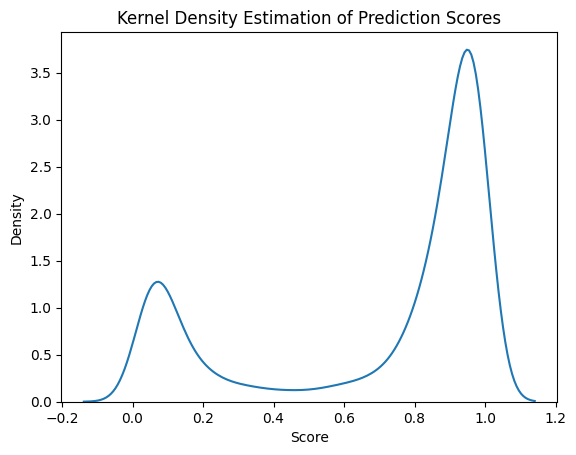

------------------------------------
Best threshold:  0.4396016
Best F1 score:  0.9647879207007838
####################################
XGB model evaluation for question 2
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.9730532569488648
Training Precision: 1.0
Validation Precision: 0.9761448349307774
Training Recall: 1.0
Validation Recall: 0.9967377120487169
Training F1 Score: 1.0
Validation F1 Score: 0.9863337996341331
Training AUC Score: 1.0
Validation AUC Score: 0.5114123342852279


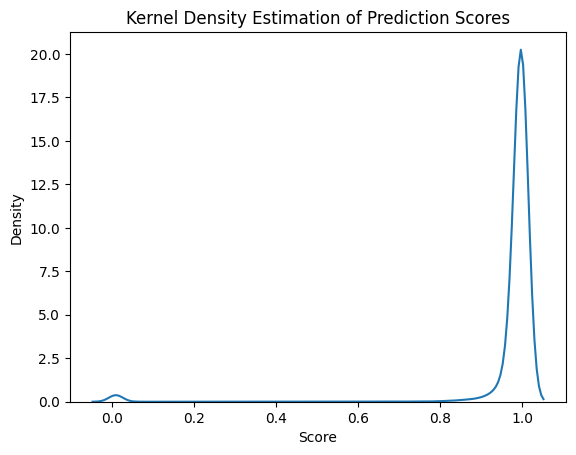

------------------------------------
Best threshold:  0.3579287
Best F1 score:  0.9975559640964636
####################################
XGB model evaluation for question 3
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.9316783365160195
Training Precision: 1.0
Validation Precision: 0.9376473109063639
Training Recall: 1.0
Validation Recall: 0.9929657363285682
Training F1 Score: 1.0
Validation F1 Score: 0.9645139960326208
Training AUC Score: 1.0
Validation AUC Score: 0.5209926720858528


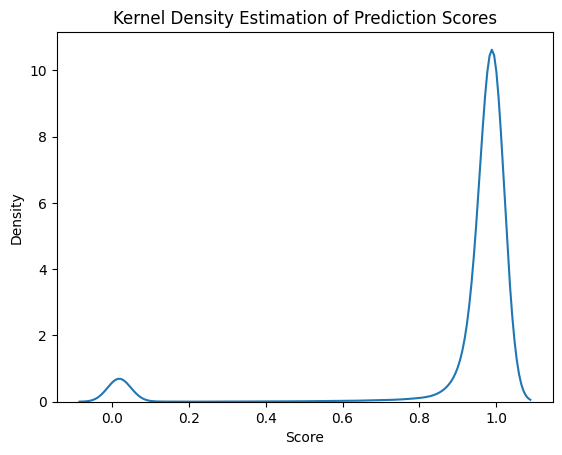

------------------------------------
Best threshold:  0.16466594
Best F1 score:  0.993139555876512
####################################
XGB model evaluation for question 4
####################################
Training Accuracy: 0.9998673388166622
Validation Accuracy: 0.7873965626989179
Training Precision: 0.9997347480106101
Validation Precision: 0.8532608695652174
Training Recall: 1.0
Validation Recall: 0.8834405144694534
Training F1 Score: 0.9998673564133175
Validation F1 Score: 0.868088467614534
Training AUC Score: 0.9998673388166622
Validation AUC Score: 0.6527294315466534


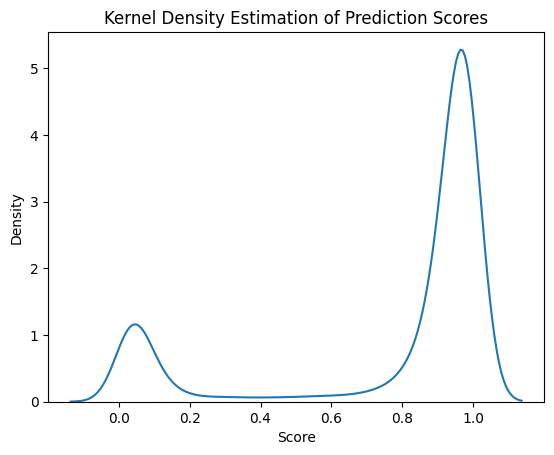

------------------------------------
Best threshold:  0.33920395
Best F1 score:  0.9763350785340313
####################################
XGB model evaluation for question 5
####################################
Training Accuracy: 0.9997572579862123
Validation Accuracy: 0.6274135370252493
Training Precision: 0.9996117258784702
Validation Precision: 0.6620352985354863
Training Recall: 0.9999029031944849
Validation Recall: 0.6731576937762505
Training F1 Score: 0.9997572933352751
Validation F1 Score: 0.6675501703900037
Training AUC Score: 0.9997572579862124
Validation AUC Score: 0.6216791334210765


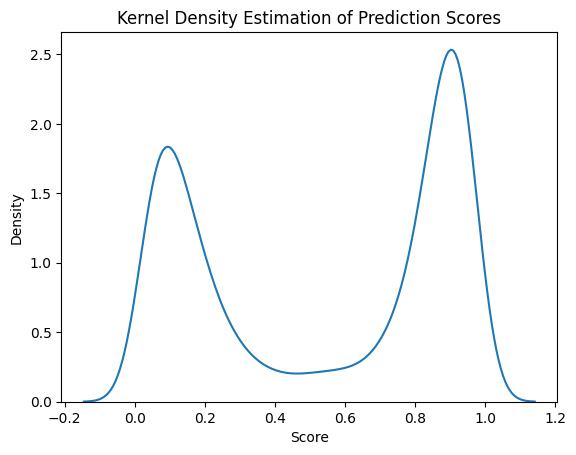

------------------------------------
Best threshold:  0.44691196
Best F1 score:  0.9377214032681979
####################################
XGB model evaluation for question 6
####################################
Training Accuracy: 0.9999656899746105
Validation Accuracy: 0.7725440271589221
Training Precision: 0.9999313846576094
Validation Precision: 0.8307422266800402
Training Recall: 1.0
Validation Recall: 0.8929919137466308
Training F1 Score: 0.999965691151748
Validation F1 Score: 0.8607430501428943
Training AUC Score: 0.9999656899746107
Validation AUC Score: 0.6100054284585597


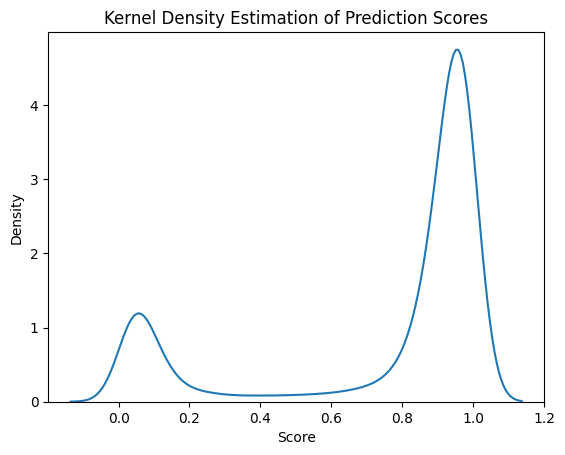

------------------------------------
Best threshold:  0.43267626
Best F1 score:  0.9733973667170299
####################################
XGB model evaluation for question 7
####################################
Training Accuracy: 0.9998191943299342
Validation Accuracy: 0.7076172289412264
Training Precision: 0.9996385193753615
Validation Precision: 0.7892316017316018
Training Recall: 1.0
Validation Recall: 0.8296359499431172
Training F1 Score: 0.999819227014715
Validation F1 Score: 0.8089295618413754
Training AUC Score: 0.9998191943299343
Validation AUC Score: 0.5894211495747332


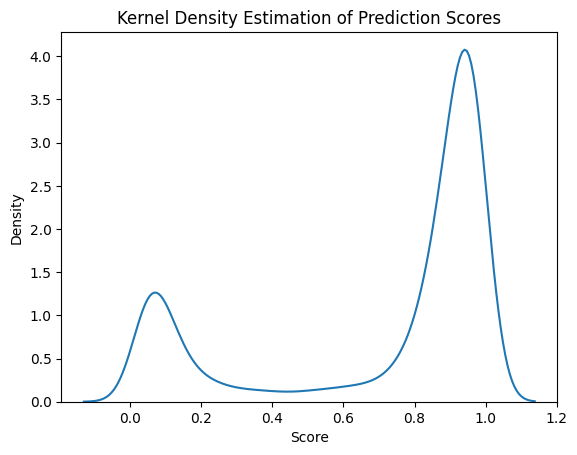

------------------------------------
Best threshold:  0.41654864
Best F1 score:  0.9652205903160992
####################################
XGB model evaluation for question 8
####################################
Training Accuracy: 0.9998269746517865
Validation Accuracy: 0.598557182261829
Training Precision: 0.9996540690132318
Validation Precision: 0.6538028169014084
Training Recall: 1.0
Validation Recall: 0.7778150134048257
Training F1 Score: 0.9998270045843785
Validation F1 Score: 0.7104377104377103
Training AUC Score: 0.9998269746517865
Validation AUC Score: 0.5334997565578206


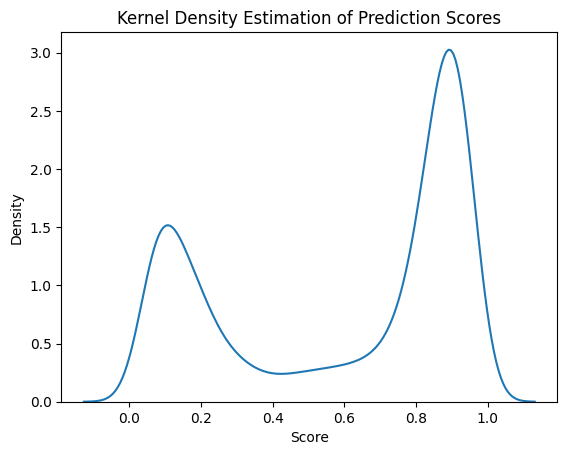

------------------------------------
Best threshold:  0.40301898
Best F1 score:  0.9394050434724674
####################################
XGB model evaluation for question 9
####################################
Training Accuracy: 0.9998547988964717
Validation Accuracy: 0.742414597920645
Training Precision: 0.9997096821019016
Validation Precision: 0.8001017293997965
Training Recall: 1.0
Validation Recall: 0.8802462227196418
Training F1 Score: 0.9998548199767712
Validation F1 Score: 0.8382627231548094
Training AUC Score: 0.9998547988964716
Validation AUC Score: 0.5950836030191713


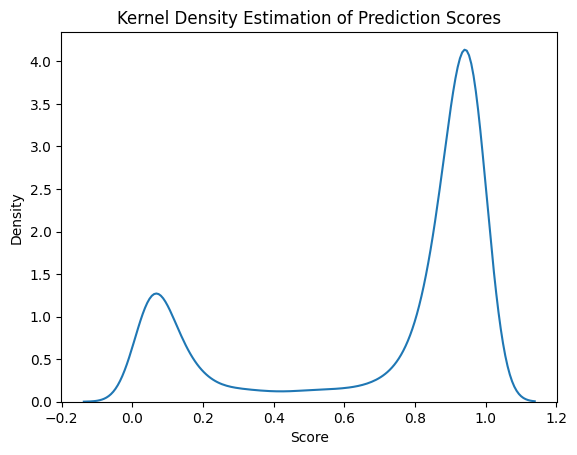

------------------------------------
Best threshold:  0.41965255
Best F1 score:  0.9674529371739624
####################################
XGB model evaluation for question 10
####################################
Training Accuracy: 0.9998946370245496
Validation Accuracy: 0.5805219605346913
Training Precision: 0.9997893184451702
Validation Precision: 0.6421663442940039
Training Recall: 1.0
Validation Recall: 0.4119106699751861
Training F1 Score: 0.9998946481247367
Validation F1 Score: 0.5018896447467877
Training AUC Score: 0.9998946370245495
Validation AUC Score: 0.5850403023078545


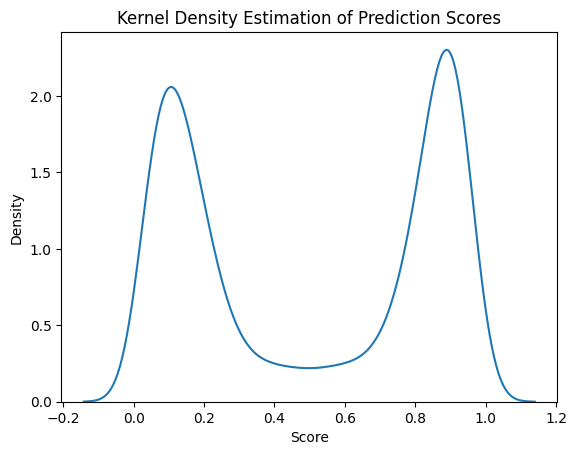

------------------------------------
Best threshold:  0.42038122
Best F1 score:  0.925203653418909
####################################
XGB model evaluation for question 11
####################################
Training Accuracy: 0.999669394164807
Validation Accuracy: 0.6378103119032463
Training Precision: 0.9993392252415958
Validation Precision: 0.6912468336616944
Training Recall: 1.0
Validation Recall: 0.8010437051532941
Training F1 Score: 0.9996695034289019
Validation F1 Score: 0.7421060583169663
Training AUC Score: 0.9996693941648069
Validation AUC Score: 0.5674921015141091


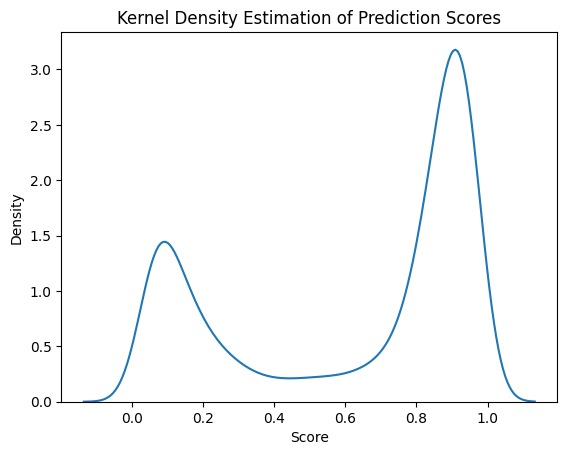

------------------------------------
Best threshold:  0.9927832
Best F1 score:  nan
####################################
XGB model evaluation for question 12
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.8576278378951835
Training Precision: 1.0
Validation Precision: 0.8760964912280702
Training Recall: 1.0
Validation Recall: 0.9741526456961717
Training F1 Score: 1.0
Validation F1 Score: 0.9225262671746911
Training AUC Score: 1.0
Validation AUC Score: 0.5254750156585433


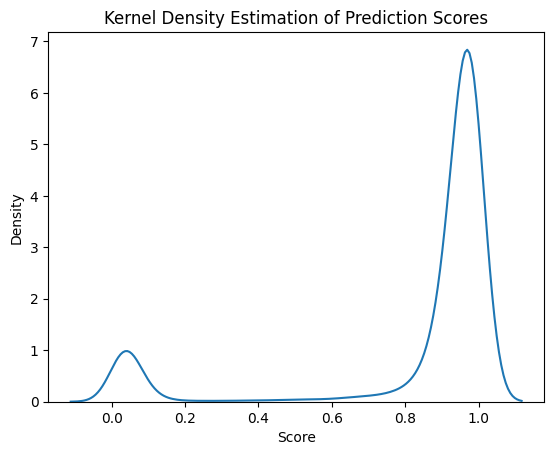

------------------------------------
Best threshold:  0.22807506
Best F1 score:  0.9848040522527326
####################################
XGB model evaluation for question 13
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.7241671971143645
Training Precision: 1.0
Validation Precision: 0.5384615384615384
Training Recall: 1.0
Validation Recall: 0.19880418535127056
Training F1 Score: 1.0
Validation F1 Score: 0.2903930131004367
Training AUC Score: 1.0
Validation AUC Score: 0.5656243148978575


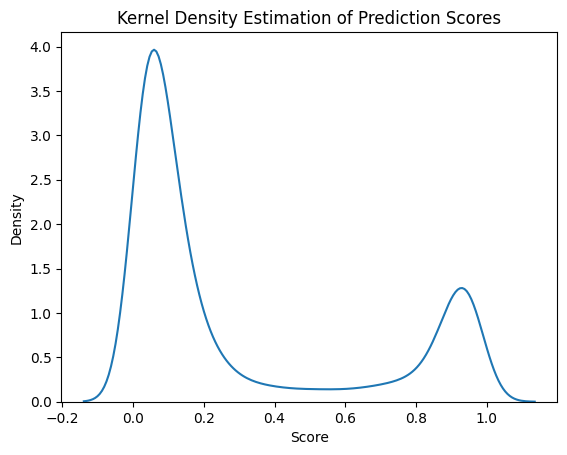

------------------------------------
Best threshold:  0.5398638
Best F1 score:  0.8935106811769448
####################################
XGB model evaluation for question 14
####################################
Training Accuracy: 0.999811106913487
Validation Accuracy: 0.6821557394440908
Training Precision: 0.9996223564954683
Validation Precision: 0.773149451168027
Training Recall: 1.0
Validation Recall: 0.7987787147426577
Training F1 Score: 0.9998111425873466
Validation F1 Score: 0.7857551487414187
Training AUC Score: 0.999811106913487
Validation AUC Score: 0.5830628267590839


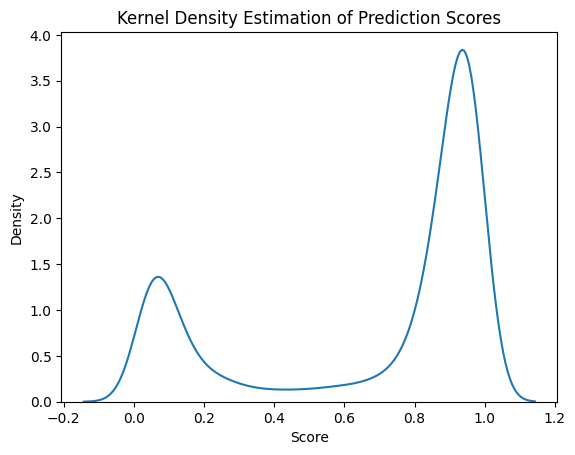

------------------------------------
Best threshold:  0.4145013
Best F1 score:  0.9629716981132076
####################################
XGB model evaluation for question 15
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.5786123488224061
Training Precision: 1.0
Validation Precision: 0.661
Training Recall: 1.0
Validation Recall: 0.28639514731369153
Training F1 Score: 1.0
Validation F1 Score: 0.3996372430471585
Training AUC Score: 1.0
Validation AUC Score: 0.5727194031786753


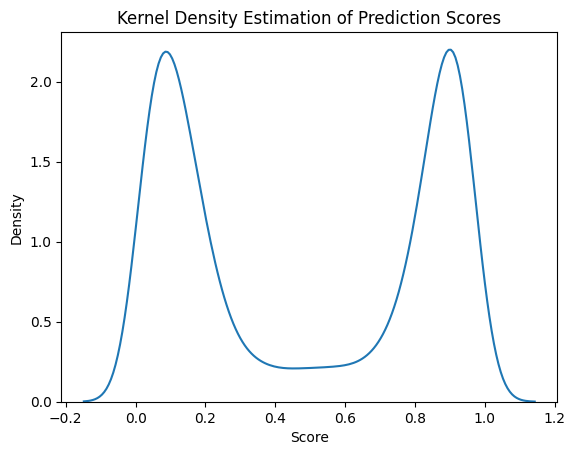

------------------------------------
Best threshold:  0.43154678
Best F1 score:  0.9265566099051087
####################################
XGB model evaluation for question 16
####################################
Training Accuracy: 0.9999637234274106
Validation Accuracy: 0.7141947803946531
Training Precision: 0.9999274521183982
Validation Precision: 0.7585798816568048
Training Recall: 1.0
Validation Recall: 0.9074178935447339
Training F1 Score: 0.9999637247433525
Validation F1 Score: 0.8263503931932449
Training AUC Score: 0.9999637234274106
Validation AUC Score: 0.5218715208621214


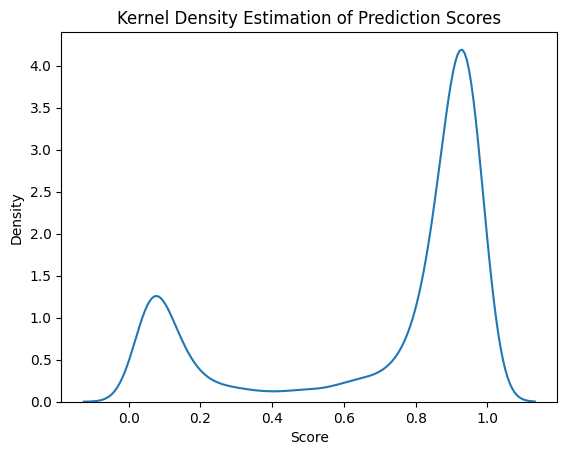

------------------------------------
Best threshold:  0.3635212
Best F1 score:  0.9644672902446559
####################################
XGB model evaluation for question 17
####################################
Training Accuracy: 0.999844840961986
Validation Accuracy: 0.6429026098026734
Training Precision: 0.9996897781914068
Validation Precision: 0.7157199471598414
Training Recall: 1.0
Validation Recall: 0.8169481302774427
Training F1 Score: 0.9998448650325783
Validation F1 Score: 0.7629911280101394
Training AUC Score: 0.9998448409619861
Validation AUC Score: 0.5233631130986355


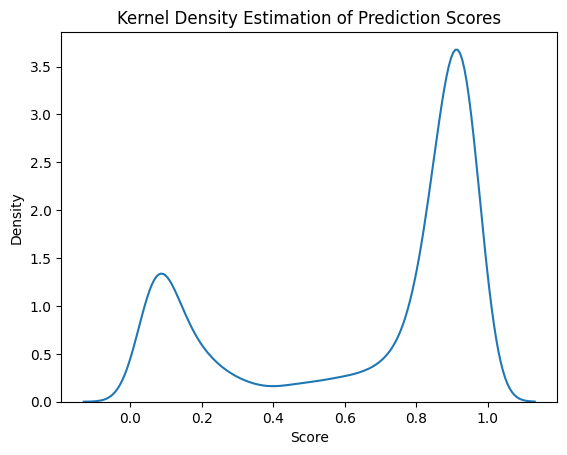

------------------------------------
Best threshold:  0.3921789
Best F1 score:  0.9556187341014514
####################################
XGB model evaluation for question 18
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.9501379164014429
Training Precision: 1.0
Validation Precision: 0.9527055815935237
Training Recall: 1.0
Validation Recall: 0.9971014492753624
Training F1 Score: 1.0
Validation F1 Score: 0.9743980825798019
Training AUC Score: 1.0
Validation AUC Score: 0.5117086193745233


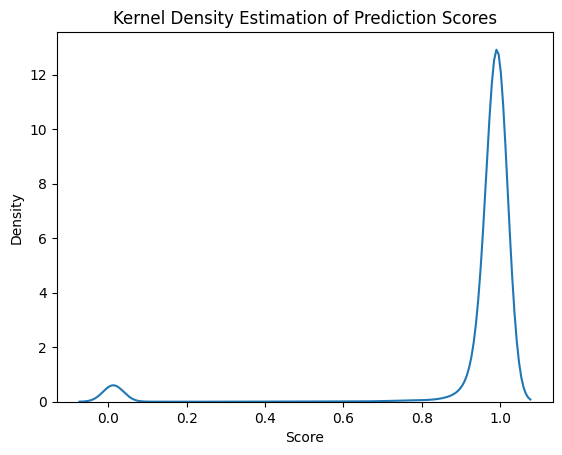

------------------------------------
Best threshold:  0.119187
Best F1 score:  0.9949362590503265
####################################


In [18]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     
best_threshold_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = FEATURES3
        
    xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df_train.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

    
    X_train = df_train[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)


    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 0)
    # clf.save_model(f'XG_boost_models/230607/XGB_question{t}.xgb')
    # print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')


    

    #Evaluating the model
    print(f'XGB model evaluation for question {t}')
    

    print(f'####################################')

    # Variables
    #X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    #y_train = train_y['correct']
    y_val = valid_y['correct']

    X = df[FEATURES].astype('float32').fillna(-1)
    train_users = df.index.values
    y = targets.loc[targets.q==t].set_index('session').loc[train_users]['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_preds)
    val_accuracy = accuracy_score(y_val, y_val_preds)

    train_precision = precision_score(y_train, y_train_preds)
    val_precision = precision_score(y_val, y_val_preds)

    train_recall = recall_score(y_train, y_train_preds)
    val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Validation Precision: {val_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")

    # Predict probabilities
    y_scores = clf.predict_proba(X)[:, 1]

    sns.kdeplot(y_scores)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Prediction Scores')
    plt.show()

    # Calculate precision-recall values for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2*recalls*precisions / (recalls+precisions)

    # Locate the index of the largest F1 score
    best_index = np.argmax(f1_scores)

    # Find the best threshold and corresponding F1 score
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_threshold_dict[t] = best_threshold
    
    print(f'------------------------------------')
    print('Best threshold: ', best_threshold)
    print('Best F1 score: ', best_f1)

    print(f'####################################')

In [107]:
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold_dict, f)

print('Best threshold saved to best_threshold.pkl')

Best threshold saved to best_threshold.pkl


XGB model evaluation for question 1
####################################
Training Accuracy: 0.7818451907262984
Validation Accuracy: 0.7224697644812221
Training Precision: 0.9192051820728291
Validation Precision: 0.8596844578717691
Training Recall: 0.7670562454346238
Validation Recall: 0.742103738046943
Training F1 Score: 0.8362666241936768
Validation F1 Score: 0.796578538102644
Training AUC Score: 0.7940728019187074
Validation AUC Score: 0.7054417263927266


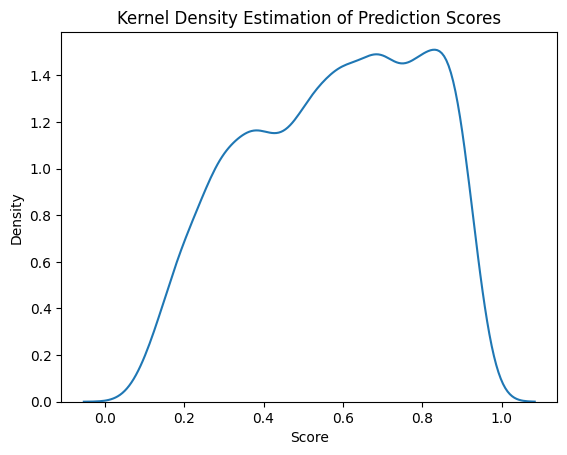

------------------------------------
Best threshold:  0.27089304
Best F1 score:  0.8531559728742827
####################################
XGB model evaluation for question 2
####################################
Training Accuracy: 0.848639185102658
Validation Accuracy: 0.8364099299809039
Training Precision: 0.9982765224052087
Validation Precision: 0.9872676343264578
Training Recall: 0.8469536961819659
Validation Recall: 0.8431926924749892
Training F1 Score: 0.9164103014854532
Validation F1 Score: 0.9095601173020529
Training AUC Score: 0.888320598090983
Validation AUC Score: 0.7042050418896686


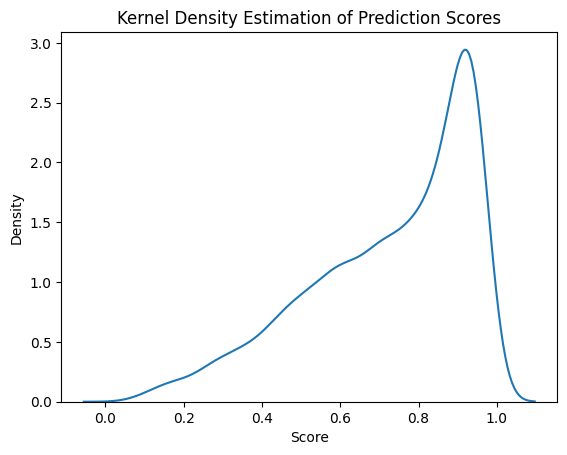

------------------------------------
Best threshold:  0.059915014
Best F1 score:  0.9876490172913758
####################################
XGB model evaluation for question 3
####################################
Training Accuracy: 0.9408987214175818
Validation Accuracy: 0.9132187566305963
Training Precision: 0.9646561443066516
Validation Precision: 0.945013357079252
Training Recall: 0.9723295454545454
Validation Recall: 0.9632402995234853
Training F1 Score: 0.9684776457272213
Validation F1 Score: 0.9540397797505338
Training AUC Score: 0.7351639720867602
Validation AUC Score: 0.5780253785199126


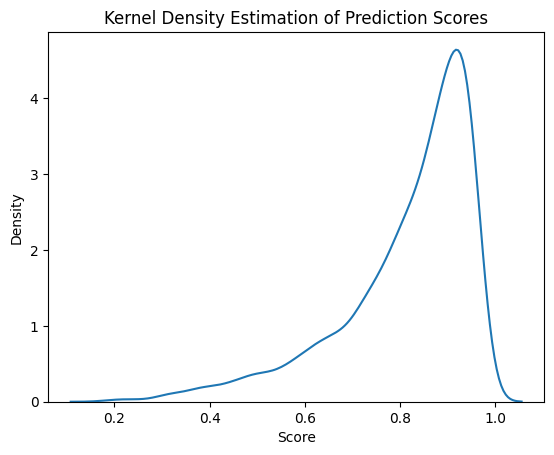

------------------------------------
Best threshold:  0.21779016
Best F1 score:  0.966864165020847
####################################
XGB model evaluation for question 4
####################################
Training Accuracy: 0.8465701098201496
Validation Accuracy: 0.8139189475917674
Training Precision: 0.8516508889401986
Validation Precision: 0.8286898457287589
Training Recall: 0.9786415494826214
Validation Recall: 0.9643622722400857
Training F1 Score: 0.9107407407407409
Validation F1 Score: 0.891393188854489
Training AUC Score: 0.6487429851839293
Validation AUC Score: 0.602976243153682


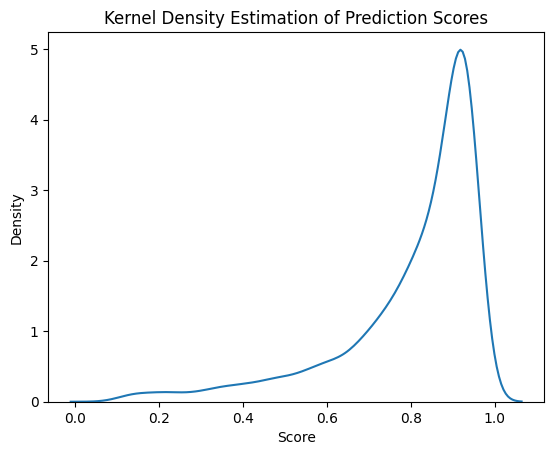

------------------------------------
Best threshold:  0.4168032
Best F1 score:  0.8943069608679752
####################################
XGB model evaluation for question 5
####################################
Training Accuracy: 0.785187543105735
Validation Accuracy: 0.6721833227243794
Training Precision: 0.7670940170940171
Validation Precision: 0.6767610269914417
Training Recall: 0.8714438294980095
Validation Recall: 0.7850324551355479
Training F1 Score: 0.8159461793717896
Validation F1 Score: 0.7268870426020858
Training AUC Score: 0.776365189602806
Validation AUC Score: 0.658036762429283


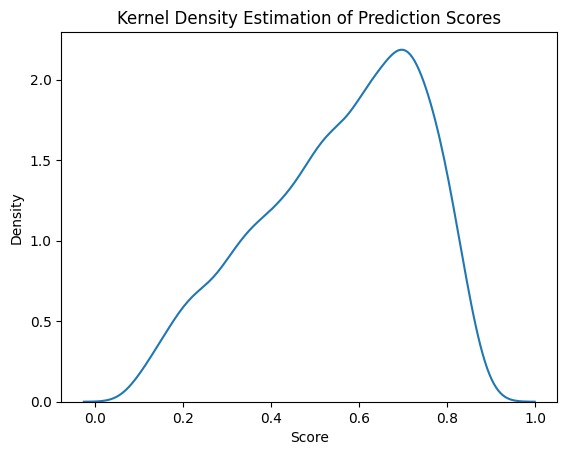

------------------------------------
Best threshold:  0.34624377
Best F1 score:  0.7467354995444884
####################################
XGB model evaluation for question 6
####################################
Training Accuracy: 0.8445010345376412
Validation Accuracy: 0.7984298748143434
Training Precision: 0.8390610438024231
Validation Precision: 0.8132092600998638
Training Recall: 0.9884718314691553
Validation Recall: 0.9657681940700809
Training F1 Score: 0.9076588639299328
Validation F1 Score: 0.8829472646623954
Training AUC Score: 0.6711535958094139
Validation AUC Score: 0.5726149046123087


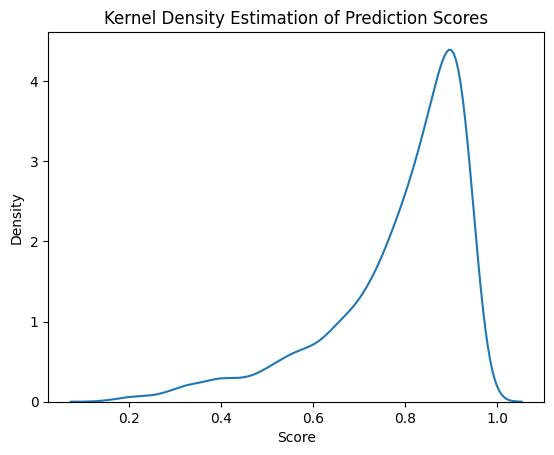

------------------------------------
Best threshold:  0.39842367
Best F1 score:  0.88719438392641
####################################
XGB model evaluation for question 7
####################################
Training Accuracy: 0.819831290784657
Validation Accuracy: 0.7545088054317844
Training Precision: 0.8097274184927846
Validation Precision: 0.7697233020809513
Training Recall: 0.9861141245389455
Validation Recall: 0.9573378839590444
Training F1 Score: 0.8892584621404813
Validation F1 Score: 0.8533400938014957
Training AUC Score: 0.6740606464988634
Validation AUC Score: 0.5580340213446016


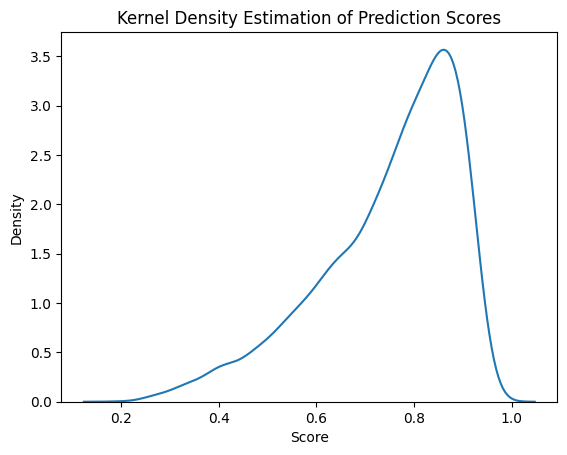

------------------------------------
Best threshold:  0.40568084
Best F1 score:  0.8553785352599728
####################################
XGB model evaluation for question 8
####################################
Training Accuracy: 0.6903283993845828
Validation Accuracy: 0.5885847655421176
Training Precision: 0.7862717630578347
Validation Precision: 0.7046611829220525
Training Recall: 0.6798165931308937
Validation Recall: 0.6028820375335121
Training F1 Score: 0.7291792325894307
Validation F1 Score: 0.649810366624526
Training AUC Score: 0.6934062389522782
Validation AUC Score: 0.5833959059848012


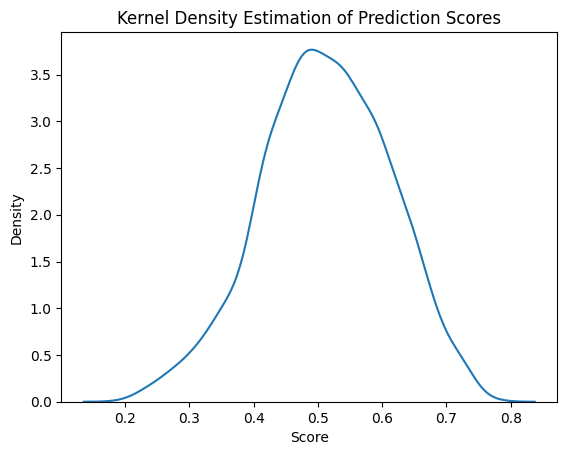

------------------------------------
Best threshold:  0.7816772
Best F1 score:  nan
####################################
XGB model evaluation for question 9
####################################
Training Accuracy: 0.8022176242771499
Validation Accuracy: 0.7750901761086357
Training Precision: 0.7937083382060578
Validation Precision: 0.7864630811303556
Training Recall: 0.9854798896471613
Validation Recall: 0.9655847789591494
Training F1 Score: 0.8792589713693484
Validation F1 Score: 0.8668676212007034
Training AUC Score: 0.6451537379270289
Validation AUC Score: 0.5714666651599961


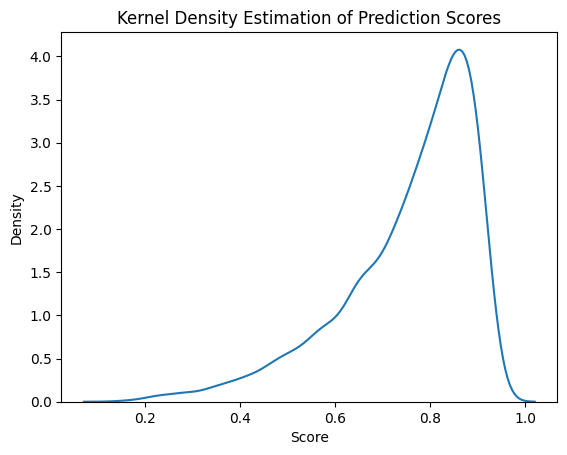

------------------------------------
Best threshold:  0.45127857
Best F1 score:  0.8691993565152827
####################################
XGB model evaluation for question 10
####################################
Training Accuracy: 0.7518170725237413
Validation Accuracy: 0.6456609378315298
Training Precision: 0.7379139891250618
Validation Precision: 0.6444015444015444
Training Recall: 0.7864292487619851
Validation Recall: 0.6902398676592225
Training F1 Score: 0.7613995715597265
Validation F1 Score: 0.6665335463258787
Training AUC Score: 0.7515711108097166
Validation AUC Score: 0.6444663390583694


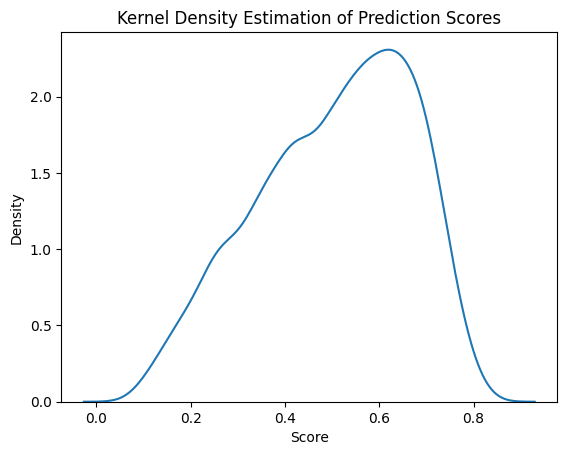

------------------------------------
Best threshold:  0.32995674
Best F1 score:  0.7055292259083727
####################################
XGB model evaluation for question 11
####################################
Training Accuracy: 0.720568730436628
Validation Accuracy: 0.6390833863781031
Training Precision: 0.8125343092406221
Validation Precision: 0.7395577395577395
Training Recall: 0.7340276055872386
Validation Recall: 0.6872146118721462
Training F1 Score: 0.77128837552651
Validation F1 Score: 0.7124260355029585
Training AUC Score: 0.7152360250158415
Validation AUC Score: 0.618349261005897


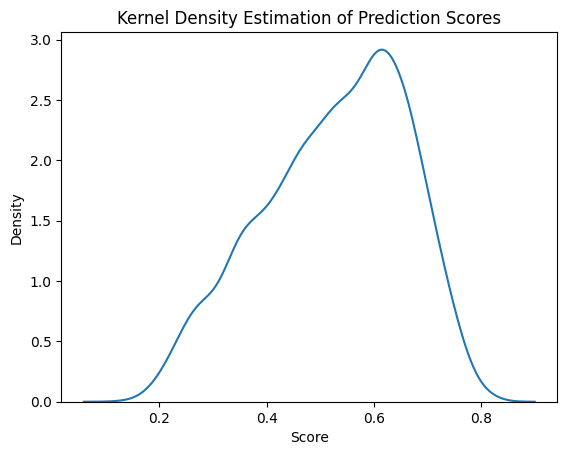

------------------------------------
Best threshold:  0.32468238
Best F1 score:  0.7938060309698453
####################################
XGB model evaluation for question 12
####################################
Training Accuracy: 0.8738925141917343
Validation Accuracy: 0.8699342244854658
Training Precision: 0.8723461435098092
Validation Precision: 0.8710638297872341
Training Recall: 0.9998767865943815
Validation Recall: 0.9982930992440868
Training F1 Score: 0.931767947871516
Validation F1 Score: 0.930348823997273
Training AUC Score: 0.5461745415585587
Validation AUC Score: 0.5040485104063571


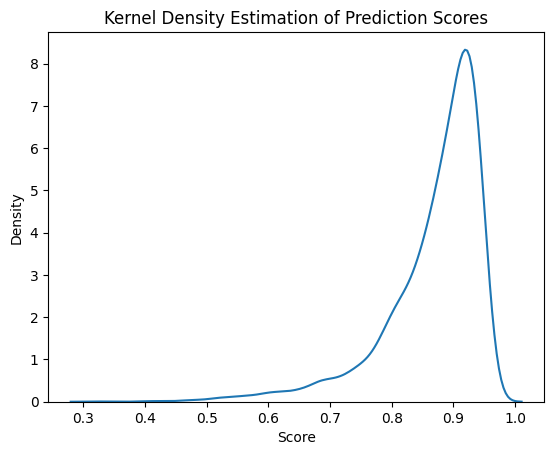

------------------------------------
Best threshold:  0.5562371
Best F1 score:  0.9308104411261826
####################################
XGB model evaluation for question 13
####################################
Training Accuracy: 0.8113958300175076
Validation Accuracy: 0.7371101209420751
Training Precision: 0.8958644743398106
Validation Precision: 0.6246851385390428
Training Recall: 0.3495334370139969
Validation Recall: 0.18535127055306427
Training F1 Score: 0.5028667319256048
Validation F1 Score: 0.2858789625360231
Training AUC Score: 0.6671417641107927
Validation AUC Score: 0.5706015612024581


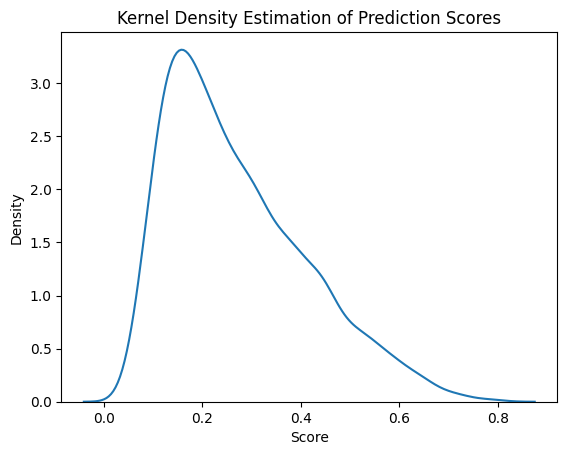

------------------------------------
Best threshold:  0.23171942
Best F1 score:  0.5036726128016789
####################################
XGB model evaluation for question 14
####################################
Training Accuracy: 0.7431693989071039
Validation Accuracy: 0.6863993210269468
Training Precision: 0.8634395566331833
Validation Precision: 0.8342993521991136
Training Recall: 0.7533811862485833
Validation Recall: 0.7115440535039256
Training F1 Score: 0.8046644877537023
Validation F1 Score: 0.7680477087256747
Training AUC Score: 0.7362381527965396
Validation AUC Score: 0.6650341931569864


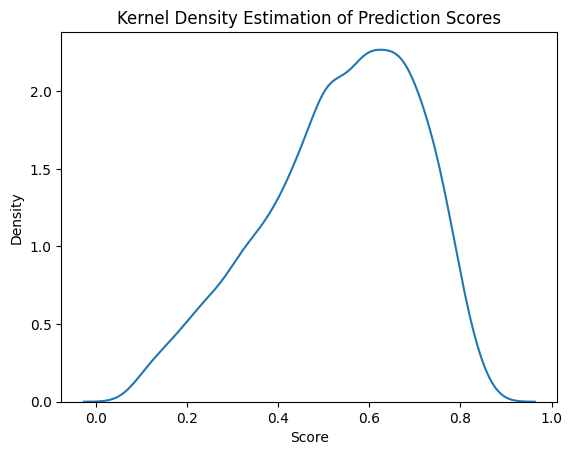

------------------------------------
Best threshold:  0.2109361
Best F1 score:  0.8516421291053229
####################################
XGB model evaluation for question 15
####################################
Training Accuracy: 0.732399596795586
Validation Accuracy: 0.6681519202206663
Training Precision: 0.7094466652640438
Validation Precision: 0.65
Training Recall: 0.7471748282738755
Validation Recall: 0.6984402079722704
Training F1 Score: 0.727822145478092
Validation F1 Score: 0.6733500417710944
Training AUC Score: 0.7329989991924198
Validation AUC Score: 0.6687627235287547


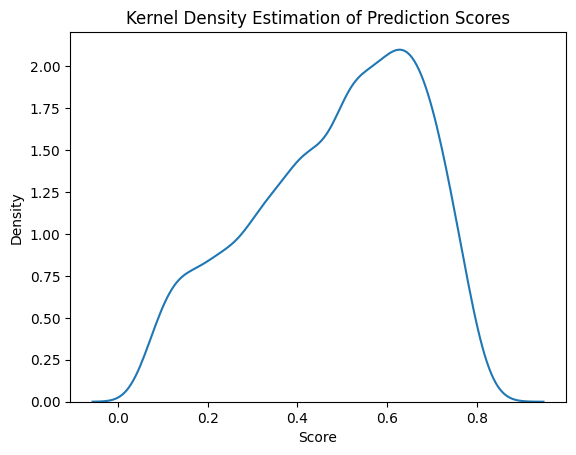

------------------------------------
Best threshold:  0.3571773
Best F1 score:  0.7069382119433896
####################################
XGB model evaluation for question 16
####################################
Training Accuracy: 0.7332484481935381
Validation Accuracy: 0.7504774029280713
Training Precision: 0.7327343293104365
Validation Precision: 0.7502124044180118
Training Recall: 0.9999274468548212
Validation Recall: 1.0
Training F1 Score: 0.8457290132547866
Validation F1 Score: 0.8572815533980582
Training AUC Score: 0.5038129141103952
Validation AUC Score: 0.502116850127011


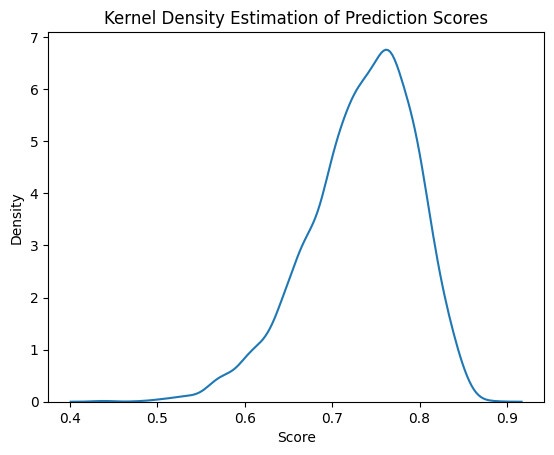

------------------------------------
Best threshold:  0.53520286
Best F1 score:  0.8580456976178902
####################################
XGB model evaluation for question 17
####################################
Training Accuracy: 0.7084195448034378
Validation Accuracy: 0.7027371101209421
Training Precision: 0.7016692123063496
Validation Precision: 0.7061356297093649
Training Recall: 0.9979053529868115
Validation Recall: 0.9891435464414958
Training F1 Score: 0.8239702773685222
Validation F1 Score: 0.8240170832809949
Training AUC Score: 0.5400669574130231
Validation AUC Score: 0.5060248870360664


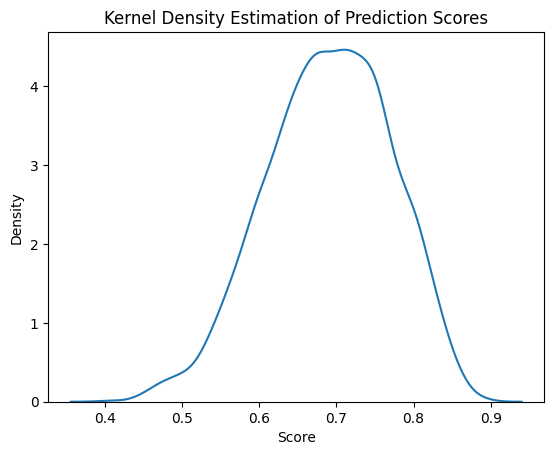

------------------------------------
Best threshold:  0.4371748
Best F1 score:  0.826211536065778
####################################
XGB model evaluation for question 18
####################################
Training Accuracy: 0.9430208499124622
Validation Accuracy: 0.9208572034797369
Training Precision: 0.9734592892487629
Validation Precision: 0.9601611459265891
Training Recall: 0.9663949983253322
Validation Recall: 0.9565217391304348
Training F1 Score: 0.9699142809120959
Validation F1 Score: 0.9583379872668379
Training AUC Score: 0.7307910820503667
Validation AUC Score: 0.587909992372235


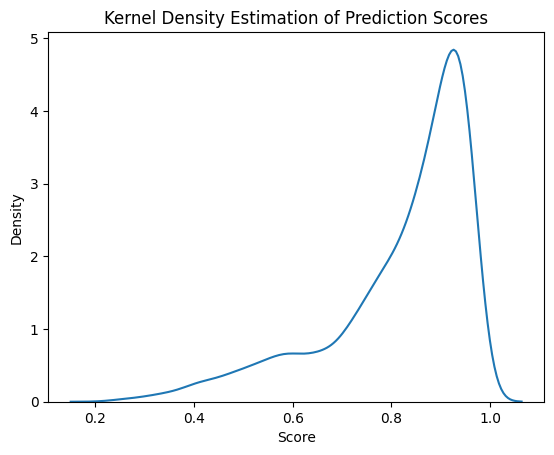

------------------------------------
Best threshold:  0.24218704
Best F1 score:  0.9753180384908123
####################################


In [29]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     
best_threshold_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] = estimators_xgb[t-1]
    xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df_train.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]



    clf =  XGBClassifier(**xgb_params)
    clf.fit(df_train[FEATURES].astype('float32'), train_y['correct'], verbose = 0)
    # clf.save_model(f'XG_boost_models/230607/XGB_question{t}.xgb')
    # print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')


    

    #Evaluating the model
    print(f'XGB model evaluation for question {t}')
    

    print(f'####################################')

    # Variables
    X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    y_train = train_y['correct']
    y_val = valid_y['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_preds)
    val_accuracy = accuracy_score(y_val, y_val_preds)

    train_precision = precision_score(y_train, y_train_preds)
    val_precision = precision_score(y_val, y_val_preds)

    train_recall = recall_score(y_train, y_train_preds)
    val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Validation Precision: {val_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")

    # Predict probabilities
    y_scores = clf.predict_proba(X_val)[:, 1]

    sns.kdeplot(y_scores)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Prediction Scores')
    plt.show()

    # Calculate precision-recall values for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2*recalls*precisions / (recalls+precisions)

    # Locate the index of the largest F1 score
    best_index = np.argmax(f1_scores)

    # Find the best threshold and corresponding F1 score
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_threshold_dict[t] = best_threshold
    
    print(f'------------------------------------')
    print('Best threshold: ', best_threshold)
    print('Best F1 score: ', best_f1)

    print(f'####################################')
    
    

### Defining threshold

In [19]:
best_threshold_dict

{1: 0.4396016,
 2: 0.3579287,
 3: 0.16466594,
 4: 0.33920395,
 5: 0.44691196,
 6: 0.43267626,
 7: 0.41654864,
 8: 0.40301898,
 9: 0.41965255,
 10: 0.42038122,
 11: 0.9927832,
 12: 0.22807506,
 13: 0.5398638,
 14: 0.4145013,
 15: 0.43154678,
 16: 0.3635212,
 17: 0.3921789,
 18: 0.119187}

# Exporting final models

In [20]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    
    X_train = df[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # #SMOTE
    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])



    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 0)
    clf.save_model(f'XG_boost_models/230609/XGB_question{t}.xgb')
    print(f'model XGB saved for question {t}')

model XGB saved for question 1
model XGB saved for question 2
model XGB saved for question 3
model XGB saved for question 4
model XGB saved for question 5
model XGB saved for question 6
model XGB saved for question 7
model XGB saved for question 8
model XGB saved for question 9
model XGB saved for question 10
model XGB saved for question 11
model XGB saved for question 12
model XGB saved for question 13
model XGB saved for question 14
model XGB saved for question 15
model XGB saved for question 16
model XGB saved for question 17
model XGB saved for question 18


# Submission

In [ ]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

count = 0

for (sample_submission, test) in iter_test:
        
        session_id = test.session_id.values[0]
        grp = test.level_group.values[0]
        a,b = limits[grp]
  

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            FEATURES = FEATURES1
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            FEATURES = FEATURES2
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            FEATURES = FEATURES3
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
    
        for t in range(a,b):

            clf = XGBClassifier()
            clf.load_model(f'/kaggle/working/XGB_question{t}.xgb')

            mask = sample_submission.session_id.str.contains(f'q{t}')
            p = clf.predict_proba(test.astype('float32'))[:,1]
            sample_submission.loc[mask,'correct'] = int((p.item())>0.625)  
                
        env.predict(sample_submission)

In [ ]:
pd.read_csv('submission.csv').head(10)

# DEBUG

### Usefull when you make updates

In [ ]:
"""
test = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv')
test = test.drop('session_level', axis=1)
test_level1 = test[test['level_group'] == '0-4']
test_level2 = test[test['level_group'] == '5-12']
test_level3 = test[test['level_group'] == '13-22']
sample_submission = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv')

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}


for test_level in [test_level1,test_level2,test_level3]:
    l = np.unique(test_level['level_group']).tolist()
    print(f'\n***************** level = {l}*******************\n')
    for session_id in [20090109393214576,20090312143683264,20090312331414616]:
        print(f'--------- {session_id} ---------')
        
        test_level_session = test_level[test_level['session_id']==session_id]          
        #display(test_level_session.head(2))
        #------------------------------------
        #grp = test.level_group.values[0]
        grp = l[0] 
        a,b = limits[grp]
        #------------------------------------           
        columns = [

            pl.col("page").cast(pl.Float32),
            (
                (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
                 .fill_null(0)
                 .clip(0, 1e9)
                 .over(["session_id", "level_group"])
                 .alias("elapsed_time_diff")
            ),
            (
                (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_x_diff") 
            ),
            (
                (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_y_diff") 
            ),
            pl.col("fqid").fill_null("fqid_None"),
            pl.col("text_fqid").fill_null("text_fqid_None")
        ]

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            print('GRP =',grp)
            FEATURES = FEATURES1
            
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            level = 3
            w = 0
            print('test shape',test_level.shape)
            print('level =',level)
          
            scaler = scaler_0

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            print('GRP =',grp)
            FEATURES = FEATURES2
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            level = 10 
            print('level =',level)
            scaler = scaler_1

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            print('GRP =',grp)
            FEATURES = FEATURES3
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            
            level = 5
            print('level =',level)
            scaler = scaler_2
         

        # ---------- Predictions for the session_id and the level_group -------------    

        X_test = scaler.transform(test)
        #X_test = scaler.transform(test)
        
        X_test = torch.from_numpy(X_test.astype(np.float32))
        pred_test = np.zeros((X_test.shape[0],level))

        for i in range(N_SPLITS) :
            with torch.no_grad():
                model = dict_level[level][i]
                model.eval()
                pred = model(X_test.float())
                pred_test += pred.numpy()/N_SPLITS
               
      
        pred_test = pred_test.tolist()[0]
        print(pred_test)           
            
        for t in range(a,b):
            w = t-a
            print(f'---------- t = {t} ----  t-a = {w} -------------')
            mask = sample_submission.session_id.str.contains(f'q{t}')
            sample_submission.loc[mask,'correct'] = int(pred_test[w]>0.61) 
            print('prediction = ',int(pred_test[w]>0.61))                  
           
        #env.predict(sample_submission)
           
"""